<a href="https://colab.research.google.com/github/maxruther/HCP_Fraud_Detection/blob/main/HCPF_Full_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare Provider Fraud Detection**
## Final Project for DSC 540
### Max Ruther

# **Overview**

This document details my approach to a data science project that I completed in my MS program at DePaul. It amply explains the project's challenges, my considerations, and my solutions. Such explanations are often written in a pedagogical tone, for newer practitioners, but that tone might not be consistent throughout the work.

**I would implore you to instead read my final report** for this project, if you are interested in a more formal example of my written work, or a higher-level summary of this project.


### **The Assignment**

In one of the final courses I took at DePaul, "Advanced Machine Learning - DSC 540," the main assignment was its final project, an independent one asking that we each find and extensively analyze a dataset using covered techniques, then present our findings.

In addition to this analysis and presentation, another primary focus of this assignment was to first read several journal articles, ones that relate to the chosen domain or analytical methods. That way, expert perspectives might inform the analysis subsequent, if not drive it.

### **My Project**

#### **My Initial Motivations**

As this course touched on many areas of applied data science, it clearly and recurrently imparted the following takeaway, especially in the domain of healthcare: the challenges of small sample size and drastic class imbalance in data analysis are persistent and nearly unavoidable.

These challenges might both be characterized by a severe scarcity of valuable information. It is my impression that in scenarios defined by such informational scarcity, every choice in the data science process becomes highly consequential. Therein, the biases of those choices might be at their most obscuring, relative to the faintness of the targeted signal.

I was intrigued by these challenges, by their ubiquity and urgency. I also knew them to affect many other important contexts aside from healthcare, like fraud detection. So motivated to get some practice with these relevant issues, I landed on the topic of healthcare provider claim fraud detection for my final project, having identified such a dataset on Kaggle.

#### **The Topic - Healthcare Claim Fraud**

The proportion of healthcare provider claims that are fraudulent is conservatively estimated to be 10%. Such exploitation is enormously draining to a healthcare system already stretched to its limits by countless other factors.

When insurance companies are compelled to pay more, whether for fraudulent claims or valid ones, they raise premiums and other costs to cover those increased payments. In this way, the financial cost of claim fraud is largely transferred to patients and their loved ones. Even before such cost increases, patients’ medical expenses are often already immense: medical debt perennially ranks as a top source of financial burden to Americans.

Claim fraud perpetrated by healthcare providers thusly effects grave harm on the public. If we improve our approaches to the identification of such fraud, it should lead to the mitigation of that public harm.

#### **The Data**

The datasets are from a Kaggle post titled, "Healthcare Provider Fraud Detection Analysis":

https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis/data


This data  consists of four different files, which separately contain records of inpatient claims, outpatient claims, beneficiaries, and
labels flagging providers as potentially fraudulent. These labels resemble one of the few publicly available sources of (real-life) labelled provider fraud data, the List of Excluded Individuals/Entities (LEIE).

#### **Optimizing for Precision**

Using this dataset, I set out to train an optimally precise classification model. I prioritize the classifier's precision over other performance metrics because I imagine that, in a real-life scenario of provider fraud detection, an investigation of immense cost might follow such detection. To avoid incurring such an expense without any reimbursement of damages, I strive to minimize the classifier's risk of falsely classifying a provider as fraud, which in this case is equivalent to maximizing its precision.

#### **Techniques Recommended by the Literature**

Throughout my analysis, I take special care to observe the myriad advisements and techniques recommended by the relevant literature. A few such observed recommendations are the following:
- **Feature engineering to aggregate** claim and patient data to the provider level.
- **Correlation-based feature selection** to interpret variable importances and drastically reduce training times.
- **Alleviating class imbalance** to a 75-25 ratio.
- **Classifying with ensemble learning methods**, which were described as particularly effective on small samples, as well as those with rebalanced class ratios.


#### **This Notebook**

This notebook document was neither demanded nor submitted as a deliverable for this course project. The project's deliverables were instead a 5-minute, in-person presentation and a 6-page written report, styled as a journal article. My submissions thereof were entirely underpinned by the analysis featured in this document, but this document itself was not submitted for the assignment. Nor was it then legibly presentable.

So to present this analysis in my portfolio, as an example of my style and decision-making in data science, I have since extensively redrafted it for legibility. This mainly involved adding ample written explanation; refactoring and modularizing code for clarity and concision; and reorganizing and retitling its various sections.

I hope these efforts successfully ease your review of this lengthy technical document. **Thank you very much for your consideration and interest.**

# **Analysis**

## **Importing Libraries**

For a resampling method that I will use later on, I need to install the Python library ***imblearn*** in this Google Colab session:

In [ ]:
!pip install imblearn

Next, I import the libraries that I'll be using:

In [ ]:
import pandas as pd
import numpy as np

import time
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import precision_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

import pickle

import warnings

## **Loading the Data**

I have already stored copies of the Kaggle data in my Google Drive. I mount my Google Drive in this Colab session, then read in the Kaggle data:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Project directory path in my Google Drive
project_dir_path = '/content/gdrive/MyDrive/fraud_data_dsc540/'
raw_file_subpath = '/data/raw_files/'

# Read in data files
bene_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Train_Beneficiarydata-1542865627584.csv')
ip_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Train_Inpatientdata-1542865627584.csv')
op_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Train_Outpatientdata-1542865627584.csv')
label_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Train-1542865627584.csv')

I have only read in the 'Train' files provided by the Kaggle post, even though 'Test' files were provided as well. I have intentionally omitted those 'Test' files because their labels are virtually empty.

I will create my own test sets later on, split from data sourced in these "Train_*" files.

(***Sidenote for the Kaggle-uninitiated:*** It is the style of Kaggle competitions to withhold the test set's labels, because competitors submit predictions thereof for grading. Here, I am conducting analysis as an academic exercise, not for a Kaggle competition. To code my acknowledgment of these omitted test files, I here include commented-out calls to read them:)

In [ ]:
# bene_test_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Test_Beneficiarydata-1542969243754.csv')
# ip_test_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Test_Inpatientdata-1542969243754.csv')
# op_test_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Test_Outpatientdata-1542969243754')
# label_test_df = pd.read_csv(f'{project_dir_path}{raw_file_subpath}Test-1542969243754.csv')

### **Preliminary checks**

To briefly look at each freshly loaded dataset, I check their shape and first few records.

I start with the beneficiary file:

In [ ]:
print(f'Number of records in the beneficiary file: {bene_df.shape[0]}')
print(f'Number of attributes in the beneficiary file: {bene_df.shape[1]}')
print()

bene_df.head(3)

Number of records in the beneficiary file: 138556
Number of attributes in the beneficiary file: 25



,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40


Moving on to the inpatient claim file:

In [ ]:
print(f'Number of records in the Inpatient file: {ip_df.shape[0]}')
print(f'Number of attributes in the Inpatient file: {ip_df.shape[1]}')
print()

ip_df.head(3)

Number of records in the Inpatient file: 40474
Number of attributes in the Inpatient file: 30



,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now checking the outpatient claim file:

In [ ]:
print(f'Number of records in the Outpatient file: {op_df.shape[0]}')
print(f'Number of attributes in the Outpatient file: {op_df.shape[1]}')
print()

op_df.head(3)

Number of records in the Outpatient file: 517737
Number of attributes in the Outpatient file: 27



,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


Finally, checking the shape of the label file:

In [ ]:
print(f'Number of records in the label file: {label_df.shape[0]}')
print(f'Number of attributes in the label file: {label_df.shape[1]}')
print()

label_df.head(3)

Number of records in the label file: 5410
Number of attributes in the label file: 2



,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No


The label file, 'Train_labels.csv', only contains 5410 records, while the other training files have more than five times that amount. If this discrepancy strikes you as confusing, or as an indication that the datasets are unreconciled, then I would agree. I would also hope you find gratification in my breakdown that follows in the next section:

### **Identifying a Challenge of Data Integration**
### *Transforming towards the labels' provider level*

The label file, 'Train_labels.csv', only contains 5410 records, while the other training files have more than five times that amount. This discrepancy owes to the fact that none of the files containing predictor data are at the prescriber level, which is the level of the label data. The 'level' of a dataset is a term that's often used to describe the item signified by each row of data.

Most of the four files provided in this Kaggle post differ in level, in what their records reflect. The records of the label file reflect healthcare providers, specifically whether they are flagged as _PotentiallyFraud_ or not.

Those of the beneficiary file reflect individual beneficiaries (a.k.a. patients.)

The records of both the *Train_Outpatient.csv* and *Train_Inpatient.csv* files reflect individual claims. They also contain attributes that appear to reference the label and beneficiary files as keys, namely *BeneID* and *Provider*.

Given how none of the claim or beneficiary datasets' levels matches that of the provider labels, **much of this Kaggle project's challenge involves data integration, to so adapt the former.** I meet that challenge by carrying out the following two steps:

  1. **Integrate the three non-label files**, by combining the claims data and then joining in the patient data. This gets me a claim-level dataset with all the original predictor attributes still available.

  2. **Aggregate on that result in feature engineering**, to transform that claim-level dataset to a provider-level one (which matches the labels.)

But before starting on all this, I need to confirm that these datasets might reference each other through keys, as well as otherwise examine how they relate. (The Kaggle post provided scant explanation of schema.)

#### **Determining tables' relationships**

##### **Verifying Foreign Keys**

###### ***Beneficiary.BeneID***

It appears that the "BeneID" field in the beneficiary data is referenced as a foreign key by both the Inpatient (IP) and Outpatient (OP) datasets. This wasn't established in the Kaggle Project's description, so I'm going to here double-check that this field does behave as a foreign key, by checking:
1. its uniqueness in the Beneficiary data and
2. whether all of its values in the IP and OP claim datasets are contained in the Beneficiary dataset. This property of a foreign key is known as the *inclusion dependency constraint.*

**Checking (1)** the uniqueness of _BeneID_ within the parent table, that of the Beneficiary file:

In [ ]:
bene_df.shape[0]

138556

In [ ]:
bene_df['BeneID'].nunique()

138556

Indeed, every *BeneID* value in the beneficiary file is unique.

Also, as shown in the following cell, all of these *BeneID* values are contained in either the IP or OP claim data. (This is helpful to know, but not necessary for defining it as a foreign key):

In [ ]:
(bene_df['BeneID'].isin(op_df['BeneID']) | bene_df['BeneID'].isin(ip_df['BeneID'])).value_counts()

,count
BeneID,
True,138556


**Checking (2)** the inclusion dependency constraint.

Are all *BeneID* values featured in the IP and OP claim files also contained in the Beneficiary file?

**OP**

In [ ]:
op_df.shape[0]

517737

In [ ]:
op_df['BeneID'].isin(bene_df['BeneID']).value_counts()

,count
BeneID,
True,517737


True for OP file.

**IP**

In [ ]:
ip_df.shape[0]

40474

In [ ]:
ip_df['BeneID'].isin(bene_df['BeneID']).value_counts()

,count
BeneID,
True,40474


True for IP file.

'BeneID' seems to be an effective foreign key in the OP and IP claim files (with the bene file being the parent.)

###### ***Labels.Provider***

**Checking (1)** the uniqueness of *Provider* within the parent table, that of the label file:

In [ ]:
label_df.shape[0]

5410

In [ ]:
label_df['Provider'].nunique()

5410

Indeed, every *Provider* value in the label file is unique.

Also, as shown in the following cell, all of these *Provider* values are contained in either the IP or OP claim data. (This is helpful to know, but not necessary for defining it as a foreign key):

In [ ]:
(label_df['Provider'].isin(op_df['Provider']) | label_df['Provider'].isin(ip_df['Provider'])).value_counts()

,count
Provider,
True,5410


**Checking (2)** the inclusion dependency constraint.

Are all *Provider* values featured in the IP and OP claim files also contained in the label file?

**OP**

In [ ]:
op_df.shape[0]

517737

In [ ]:
op_df['Provider'].isin(label_df['Provider']).value_counts()

,count
Provider,
True,517737


True for OP file.

**IP**

In [ ]:
ip_df.shape[0]

40474

In [ ]:
ip_df['Provider'].isin(label_df['Provider']).value_counts()

,count
Provider,
True,40474


True for IP file.

*Provider* is an effective foreign key in the OP and IP claim files (referencing that same attribute in the label file as parent.)

##### **Comparing the OP and IP claims tables**
##### *Specifically, comparing their attribute sets.*

These tables appear to be similar, but if there are any attributes that exclusive to one or the other, I want to identify them. I do so programmatically:

In [ ]:
op_df_cols = op_df.columns.values.tolist()
ip_df_cols = ip_df.columns.values.tolist()
OP_only_cols = [x for x in op_df_cols if x not in ip_df_cols]
IP_only_cols = [x for x in ip_df_cols if x not in op_df_cols]

print(f'{OP_only_cols=}')
print(f'{IP_only_cols=}')

OP_only_cols=[]
IP_only_cols=['AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode']


There are no attributes in the OP claim data that aren't featured in that of the IP claims.

**However, there are three attributes that are exclusive to the IP claim data**:
- *AdmissionDt*
- *DischargeDt*
- *DiagnosisGroupCode*.


This concludes my investigation of the tables' relationships. With this deeper familiarity, I proceed with integrating the datasets.

<a name="data-integration-i"></a>
## **Data Integration I**

### **Merge all claims, then join in the beneficiaries.**

This section concerns a central task of this project, the integration of predictor data from their various files. This task might break down into the following three subtasks:

1. Combine all of the records of the Outpatient and Inpatient claim files to form one set.
2. Join that set to the patient-level data, that which comprises the beneficiary file.
3. Use feature engineering to aggregate over providers, to create a set of provider-level features on which I will train my classifiers of provider fraudulence.

Completing the first two of these subtasks makes up this current section, "Data Integration I." The last of these is completed in the "Feature Engineering" section that follows.

After that, the results of these are drawn from to create full datasets of predictors and labels, in the *Data Integration II* section. That part concludes my integration work and sets the stage for the ensuing EDA.

### **Merging the outpatient and inpatient claim data**

To merge the records from these two similar datasets, I concatenate these sets along the index axis (i.e. stacking them vertically to combine their rows.)

I execute this with an inner join, so only the attributes shared by these form the merged result.

#### **Noting claim records' table of origin**

Before concatentating, I create an attribute *PatType* in both claims datasets where I indicate the record's origin as either *Inpatient* or *Outpatient*. This way, I avoid losing that important information once these are merged.

In [ ]:
ip_df['PatType'] = 'Inpatient'
op_df['PatType'] = 'Outpatient'

To check for this change, glancing at a few records from these datasets:

In [ ]:
ip_df.iloc[:3, [1,-1]]

,ClaimID,PatType
0,CLM46614,Inpatient
1,CLM66048,Inpatient
2,CLM68358,Inpatient


In [ ]:
op_df.iloc[:3, [1,-1]]

,ClaimID,PatType
0,CLM624349,Outpatient
1,CLM189947,Outpatient
2,CLM438021,Outpatient


#### **Executing the merge**

I merge the outpatient and inpatient claim datasets by concatenating them, using an inner join:

In [ ]:
AllP_train = pd.concat([op_df, ip_df], axis=0, join='inner')
AllP_train.iloc[[0,1,2,-3,-2,-1], [1,-1]]

,ClaimID,PatType
0,CLM624349,Outpatient
1,CLM189947,Outpatient
2,CLM438021,Outpatient
40471,CLM76485,Inpatient
40472,CLM79949,Inpatient
40473,CLM69948,Inpatient


Checking the row count of the merged result against the sum of those of its composing sets:

In [ ]:
print(f'Count of outpatient claims: {op_df.shape[0]}')
print(f'Count of inpatient claims: {ip_df.shape[0]}')

AllP_train['PatType'].value_counts()

Count of outpatient claims: 517737
Count of inpatient claims: 40474


,count
PatType,
Outpatient,517737
Inpatient,40474


In [ ]:
AllP_train.shape[0] == ip_df.shape[0] + op_df.shape[0]

True

### **Joining the claims and beneficiary data**

Before I make this next combination, joining this claims data I've just concatenated to the beneficiary data, I first perform a couple checks.

First, I glance at the first several records of the beneficiary data,  to refresh my sense of it:

In [ ]:
bene_df.head(3)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40


Next, I reconfirm that the inclusion dependency constraint of the foreign key _BeneID_ has persisted through the concatenation of the claims datasets.

(This is equivalent to checking that all _BeneID_ values in the dataset of merged claims are also present in that same attribute of the beneficiary file.)

In [ ]:
print(f'Combined IP and OP claim records: {AllP_train.shape[0]}')
AllP_train['BeneID'].isin(bene_df['BeneID']).value_counts()

Combined IP and OP claim records: 558211


,count
BeneID,
True,558211


With those confirmed, I **execute the join** and then glance at the result's first few records:

In [ ]:
AllPnB_train = pd.merge(AllP_train, bene_df, how='inner', on='BeneID')
AllPnB_train.head(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,2,2,0,0,30,50
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,2,2,1,2,2,2,0,0,90,40
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,2,2,1,2,2,2,0,0,90,40


To finish, I assign `AllPnB_train` to new variable `df`, merely because 'df' is much faster to type. (This convenience can be crucial to deftly manipulating and explorating data, in my experience.)

In [ ]:
df = AllPnB_train

<a name="feature-engineering"></a>
## **Feature Engineering**

With the various predictor datasets now combined, the focus of my data integration shifts from merging to aggregation.

By aggregating many of the existing attributes by provider, I engineer features that are at the same level as the labels. These aggregate features will exclusively form the training data for my classification models.

Each provider-level aggregation relates to either **patient** or **claim** information. The **claim** aggregations involve their counts, amounts, and lengths.

The **patient** aggregations concern one of the following:
1. The **percentage prevalence of chronic conditions** among a provider's patients.
2. A provider's patients' **average annual reimbursement and deductible amounts**, meaning those of their insurance coverage.

Every attribute created in this section will be named with the prefix "Prv_". This is to indicate that it is a provider-level aggregation.

### **Claim-related aggregations by provider**



#### **Total Claim Count**
#### *Prv_Claim_Count*

Calculating the total counts of claims, by provider:

In [ ]:
df.groupby('Provider').size().head(3)

,0
Provider,
PRV51001,25
PRV51003,132
PRV51004,149


In [ ]:
df['Prv_Claim_Count'] = df.groupby('Provider')['ClaimID'].transform('count')

##### *peek_df_for_new_attr()*

Often when I create an attribute, I like to eyeball the success of its creation by taking quick "peek" at the transformed dataset. To that end, below I define a function *peek_df_for_new_attr*.

Given the name of the new attribute, it returns its  values for the first few listed providers, those listed in the code cell two previous ('PRV51001', 'PRV51003', and 'PRV51004'.)

In [ ]:
def peek_df_for_new_attr(new_attr):
  # Create a list of the first three
  first_few_prvs = list(df.groupby('Provider').size().head().index[:3].values)
  clm_and_prvIDs = ['ClaimID', 'Provider']

  # Following is a chain of query clauses, effectively:

  # Suppress a warning about reindexing dangers (I'm only querying to view, so
  # I feel somewhat comfortable with this choice.)
  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # 1. Drop duplicates from df (temporarily)
    result_df = df.drop_duplicates(subset='Provider')\
    [df['Provider'].isin(first_few_prvs)]\
    [clm_and_prvIDs + [new_attr]]\
    .sort_values(by='Provider')

  return result_df


In [ ]:
peek_df_for_new_attr('Prv_Claim_Count')

,ClaimID,Provider,Prv_Claim_Count
2572,CLM733300,PRV51001,25
1056,CLM374220,PRV51003,132
4172,CLM264498,PRV51004,149


#### **Total Claim Amount**
#### *Prv_Claim_AmtTotal*

Calculating the total amount reimbursed for claims, by provider.

In [ ]:
df.groupby('Provider').sum('InscClaimAmtReimbursed')['InscClaimAmtReimbursed'].head(3)

,InscClaimAmtReimbursed
Provider,
PRV51001,104640
PRV51003,605670
PRV51004,52170


In [ ]:
df['Prv_Claim_AmtTotal'] = df.groupby('Provider')['InscClaimAmtReimbursed'].transform('sum')

Peeking at `df` to see the implemented change:

In [ ]:
peek_df_for_new_attr('Prv_Claim_AmtTotal')

,ClaimID,Provider,Prv_Claim_AmtTotal
2572,CLM733300,PRV51001,104640
1056,CLM374220,PRV51003,605670
4172,CLM264498,PRV51004,52170


#### **Average Claim Amount**
#### *Prv_Claim_AmtAvg*

Calculating the average amount reimbursed for claims, by provider.



In [ ]:
df.groupby('Provider').mean('InscClaimAmtReimbursed')['InscClaimAmtReimbursed'].head(3)

,InscClaimAmtReimbursed
Provider,
PRV51001,4185.600000
PRV51003,4588.409091
PRV51004,350.134228


In [ ]:
df['Prv_Claim_AmtAvg'] = df.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')

Peeking at `df` to see the implemented change:

In [ ]:
peek_df_for_new_attr('Prv_Claim_AmtAvg')

,ClaimID,Provider,Prv_Claim_AmtAvg
2572,CLM733300,PRV51001,4185.600000
1056,CLM374220,PRV51003,4588.409091
4172,CLM264498,PRV51004,350.134228


#### **Inpatient Share of Claims**
#### *Prv_Claim_IPShare*

Calculating the share of claims that are associated with inpatients, by provider.

In [ ]:
df['PatType'].value_counts()

,count
PatType,
Outpatient,517737
Inpatient,40474


In [ ]:
df['isInpatient'] = pd.factorize(df['PatType'])[0]
df[['PatType','isInpatient']].value_counts()

,,count
PatType,isInpatient,
Outpatient,0,517737
Inpatient,1,40474


In [ ]:
df.groupby('Provider').mean('isInpatient')['isInpatient'].head(3)

,isInpatient
Provider,
PRV51001,0.200000
PRV51003,0.469697
PRV51004,0.000000


In [ ]:
df['Prv_Claim_IPShare'] = df.groupby('Provider')['isInpatient'].transform('mean')

Peeking at `df` to see the implemented change:

In [ ]:
peek_df_for_new_attr('Prv_Claim_IPShare')

,ClaimID,Provider,Prv_Claim_IPShare
2572,CLM733300,PRV51001,0.200000
1056,CLM374220,PRV51003,0.469697
4172,CLM264498,PRV51004,0.000000


#### **Average Claim Length**

#### *Prv_Claim_LengthAvg*

Calculating the average length of claims, by provider.

Claim length isn't a given attribute in this data, but their start and end dates are. given data does not include a dedicated attribute for claim length, but instead gives claims' start and end dates. So I construct claim length from the difference of those dates, then average that to create an attribute for average claim length.

##### **Creating the _ClaimLength_ field**

I am creating this _ClaimLength_ attribute in the exact same way that I created the _LengthOfStay_ attribute in a prior section. (That was in the last subsection of the "Examining table relationships" section.)

I am measuring the difference in days between a claim's end date and its start date.

In [ ]:
df[['ClaimStartDt', 'ClaimEndDt']][df['ClaimStartDt'] < df['ClaimEndDt']].head(3)

,ClaimStartDt,ClaimEndDt
8,2009-04-25,2009-05-15
9,2009-05-04,2009-05-16
21,2009-09-30,2009-10-20


In [ ]:
df['ClaimLength'] = (pd.to_datetime(df['ClaimEndDt']) - pd.to_datetime(df['ClaimStartDt'])).dt.days

In [ ]:
df[['ClaimStartDt', 'ClaimEndDt', 'ClaimLength']][df['ClaimStartDt'] < df['ClaimEndDt']].head(3)

,ClaimStartDt,ClaimEndDt,ClaimLength
8,2009-04-25,2009-05-15,20
9,2009-05-04,2009-05-16,12
21,2009-09-30,2009-10-20,20


Checking for any negative _ClaimLength_ values, which would strike me as invalid:

In [ ]:
df[df['ClaimLength'] < 0]

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Prv_Claim_Count,Prv_Claim_AmtTotal,Prv_Claim_AmtAvg,isInpatient,Prv_Claim_IPShare,ClaimLength


No negative *ClaimLength* values.

In [ ]:
df[df['ClaimLength'] >= 0].shape[0] == df.shape[0]

True

##### **Averaging *ClaimLength* by Provider**

In [ ]:
df.groupby('Provider').mean('ClaimLength')['ClaimLength'].head(3)

,ClaimLength
Provider,
PRV51001,1.440000
PRV51003,3.674242
PRV51004,1.429530


In [ ]:
df['Prv_Claim_LengthAvg'] = df.groupby('Provider')['ClaimLength'].transform('mean')

Peeking at `df` to see the implemented change:

In [ ]:
peek_df_for_new_attr('Prv_Claim_LengthAvg')

,ClaimID,Provider,Prv_Claim_LengthAvg
2572,CLM733300,PRV51001,1.440000
1056,CLM374220,PRV51003,3.674242
4172,CLM264498,PRV51004,1.429530


This was the last of the claim-related aggregations. Next, I turn to those relating to patients.

### **Patient-related aggregations by provider**

My aggregation process in this section differs slightly than in that preceding. Instead of creating one aggregate feature at a time, as I did for the claim-related ones, I here create multiple aggregate features at once.

To execute this for both subject areas of my patient-related aggregation, _Chronic Condition_ and _Insurance Amount_, I take the following steps:
1. Identify the relevant attributes in a list, by a common pattern in their names.
2. For the aggregation, group by both provider *and patient*, then by provider again, then take the averages.
3. Rename these transformed, aggregate attributes to reflect the change.
4. Join these to the main dataset, by the _Provider_ attribute.






#### **Chronic Condition Prevalence**

This data includes many flags indicating whether a patient suffers from a given chronic condition. With this first set of patient-related aggregations, I measure the percentage prevalences of those chronic conditions among each provider's patients.

This is information that once struck me as helpful in identifying or distinguishing providers, perhaps by specialty or just by focus, more informally. However, after reading in relevant literature that provider specialty was found to be an insignificant predictor of fraud, I became more pessimistic about its value.

##### **Identifying the relevant attributes**

First, identifying the chronic condition flag attributes by their prefix, 'ChronicCond_':

In [ ]:
cond_attrs = [x for x in df.columns.values.tolist() if 'ChronicCond_' in x]
cond_attrs

['ChronicCond_Alzheimer',
 'ChronicCond_Heartfailure',
 'ChronicCond_KidneyDisease',
 'ChronicCond_Cancer',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_IschemicHeart',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke']

##### **Executing the aggregation**

###### **Adjusting the _ChronicCond_ mapping**

The chronic condition attributes use the value '2' to represent that the patient does not suffer from the condition. The value '1' indicates the positive case.

I am remapping these '2' values to '0' instead. That way, if every patient is uniquely represented, I can average these values to calculate prevalence percentages.

Viewing the first few rows projected over these attributes, both before and after I implement the remapping:

In [ ]:
df[cond_attrs].head(3)

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,2,2,2,2,2,2,2,2,2,2,2
1,1,2,2,2,2,2,2,1,2,2,2
2,1,2,2,2,2,2,2,1,2,2,2


In [ ]:
df[cond_attrs] = df[cond_attrs].replace(2, 0)
df[cond_attrs].head(3)

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0


###### **Aggregating**

What I'm trying to measure is the prevalence of the given chronic conditions among each provider's patients.

To calculate this, I first group by both provider and patient, than take the maximum of those _ChronicCond_ values as a means of eliminating duplicates. Because every claim record shows the same _ChronicCond_ value for each patient, I could also take the minimum of these and get the same result.

Next, I group by provider again and take the average. By taking the average of these unique patients' binary flags, which show '1' in the positive case and '0' in the negative, I arrive at a prevalence percentage for that condition.

In [ ]:
PatCondPrevs_byPrv = df[['Provider', 'BeneID',] + cond_attrs].groupby(['Provider', 'BeneID']).max().groupby('Provider').mean()
PatCondPrevs_byPrv.head(3)

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
Provider,,,,,,,,,,,
PRV51001,0.583333,0.750000,0.708333,0.208333,0.375000,0.375000,0.833333,0.916667,0.250000,0.333333,0.208333
PRV51003,0.376068,0.598291,0.444444,0.085470,0.282051,0.401709,0.743590,0.846154,0.239316,0.273504,0.076923
PRV51004,0.434783,0.594203,0.340580,0.115942,0.268116,0.434783,0.695652,0.710145,0.311594,0.297101,0.115942


##### **Renaming these new aggregate features**

For my own reference in this renaming, I re-print the existing names of the chronic condition attributes:

In [ ]:
cond_attrs

['ChronicCond_Alzheimer',
 'ChronicCond_Heartfailure',
 'ChronicCond_KidneyDisease',
 'ChronicCond_Cancer',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_IschemicHeart',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke']

I next draft the new names for these attributes, ones that better reflect their new measures.

After I manually specify abbreviated descriptions of each condition, I programmatically prefix the attribute names with 'Prv_condPrev_' to indicate that they are provider-level aggregations of chronic condition prevalence:

In [ ]:
abbrvd_conds = ['Alz', 'HeartF', 'KidneyD', 'Cancer', 'ObstrP', 'Depr',
                'Diab', 'IschemicH', 'Osteo', 'Rheuma', 'Stroke']

renamedCondCols = ['Prv_condPrev_' + cond for cond in abbrvd_conds]
renamedCondCols

['Prv_condPrev_Alz',
 'Prv_condPrev_HeartF',
 'Prv_condPrev_KidneyD',
 'Prv_condPrev_Cancer',
 'Prv_condPrev_ObstrP',
 'Prv_condPrev_Depr',
 'Prv_condPrev_Diab',
 'Prv_condPrev_IschemicH',
 'Prv_condPrev_Osteo',
 'Prv_condPrev_Rheuma',
 'Prv_condPrev_Stroke']

The dataframe method 'rename' will rename variables if I pass it a dictionary mapping of the desired renamings.

Using the lists of variable names just formed, I create this mapping by entering them as arguments in a combined call to the zip() and dict() methods:

In [ ]:
condRenaming_dict = dict(zip(cond_attrs, renamedCondCols))
condRenaming_dict

{'ChronicCond_Alzheimer': 'Prv_condPrev_Alz',
 'ChronicCond_Heartfailure': 'Prv_condPrev_HeartF',
 'ChronicCond_KidneyDisease': 'Prv_condPrev_KidneyD',
 'ChronicCond_Cancer': 'Prv_condPrev_Cancer',
 'ChronicCond_ObstrPulmonary': 'Prv_condPrev_ObstrP',
 'ChronicCond_Depression': 'Prv_condPrev_Depr',
 'ChronicCond_Diabetes': 'Prv_condPrev_Diab',
 'ChronicCond_IschemicHeart': 'Prv_condPrev_IschemicH',
 'ChronicCond_Osteoporasis': 'Prv_condPrev_Osteo',
 'ChronicCond_rheumatoidarthritis': 'Prv_condPrev_Rheuma',
 'ChronicCond_stroke': 'Prv_condPrev_Stroke'}

I use the `rename()` method to apply this mapping to my temporary dataframe of prevalence percentages, `PatCondPrevs_byPrv`:

In [ ]:
PatCondPrevs_byPrv.rename(columns=condRenaming_dict, inplace=True)
PatCondPrevs_byPrv.head(3)

,Prv_condPrev_Alz,Prv_condPrev_HeartF,Prv_condPrev_KidneyD,Prv_condPrev_Cancer,Prv_condPrev_ObstrP,Prv_condPrev_Depr,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke
Provider,,,,,,,,,,,
PRV51001,0.583333,0.750000,0.708333,0.208333,0.375000,0.375000,0.833333,0.916667,0.250000,0.333333,0.208333
PRV51003,0.376068,0.598291,0.444444,0.085470,0.282051,0.401709,0.743590,0.846154,0.239316,0.273504,0.076923
PRV51004,0.434783,0.594203,0.340580,0.115942,0.268116,0.434783,0.695652,0.710145,0.311594,0.297101,0.115942


##### **Joining these features to the main dataset**

I complete this aggregation over patients' chronic conditions by integrating the attributes to the working dataset, via an inner join.

In [ ]:
df = df.merge(PatCondPrevs_byPrv, how='inner', on='Provider')

In [ ]:
df[['BeneID', 'ClaimID', 'Provider'] + renamedCondCols].head()

,BeneID,ClaimID,Provider,Prv_condPrev_Alz,Prv_condPrev_HeartF,Prv_condPrev_KidneyD,Prv_condPrev_Cancer,Prv_condPrev_ObstrP,Prv_condPrev_Depr,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke
0,BENE11002,CLM624349,PRV56011,0.359966,0.510309,0.316151,0.128007,0.256873,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165
1,BENE11003,CLM189947,PRV57610,0.562500,0.437500,0.375000,0.187500,0.250000,0.187500,0.687500,0.812500,0.187500,0.375000,0.000000
2,BENE11003,CLM438021,PRV57595,0.375000,0.500000,0.333333,0.208333,0.375000,0.250000,0.666667,0.708333,0.375000,0.375000,0.041667
3,BENE11004,CLM121801,PRV56011,0.359966,0.510309,0.316151,0.128007,0.256873,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165
4,BENE11004,CLM150998,PRV56011,0.359966,0.510309,0.316151,0.128007,0.256873,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165


#### **Average Amounts of the Patients' Reimbursements and Deductibles**

Though they relate to claims, patients' annual reimbursement amounts and deductibles are also featured in the beneficiary/patient file. For each patient, these measures are separately taken for their inpatient and outpatient costs.



##### **Identifying the relevant attributes**

First, identifying the pertinent attributes. A variable name containing 'Annual' as a substring indicates it as one of these coverage-related fields of interest.

Creating a list of these attributes' names:

In [ ]:
pat_ins_amt_attrs = [x for x in df.columns.tolist() if 'Annual' in x]
pat_ins_amt_attrs

['IPAnnualReimbursementAmt',
 'IPAnnualDeductibleAmt',
 'OPAnnualReimbursementAmt',
 'OPAnnualDeductibleAmt']

##### **Executing the aggregation**



Conveniently, this aggregation is done in the exact same way as that in the previous section, even though we are now aggregating over integers instead of binary flags.

The aggregation, coded below, involves these two steps:
1. Group by provider and patient and take the maximums of the insurance amount attributes, to deduplicate.
2. Group those by provider and take their average.


In [ ]:
patInsAmtByPrv_df = df[['Provider', 'BeneID'] + pat_ins_amt_attrs].groupby(['Provider', 'BeneID']).max().groupby('Provider').mean()
patInsAmtByPrv_df.head(3)

,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
Provider,,,,
PRV51001,18047.916667,890.000000,2537.500000,474.916667
PRV51003,6814.017094,822.632479,2490.598291,664.529915
PRV51004,4596.739130,454.144928,2095.144928,600.869565


##### **Renaming these latest aggregate features**

I print the existing names of the attributes for my reference in renaming:

In [ ]:
pat_ins_amt_attrs

['IPAnnualReimbursementAmt',
 'IPAnnualDeductibleAmt',
 'OPAnnualReimbursementAmt',
 'OPAnnualDeductibleAmt']

Next, I programmatically draft new names for these attributes:

In [ ]:
ins_amt_attr_renamings = []

# Programmatically draft each attr's name by parsing the existing one
for attr_name in pat_ins_amt_attrs:

  # Parse the patient type: 'IP' or 'OP'
  pat_type = attr_name[:2]

  # Parse amount type: 'Deductible' or 'Reimbursement'
  amt_type = attr_name[8:attr_name.index('Amt')]

  # Abbreviate this amount type string
  amt_type = amt_type.replace('Reimbursement', 'Reimb')
  amt_type = amt_type.replace('Deductible', 'Deduct')

  # Prepend with 'Prv_InsAmt_' and add to the list of new attr names.
  ins_amt_attr_renamings.append(f'Prv_InsAmt_{pat_type}_{amt_type}Avg')

ins_amt_attr_renamings

['Prv_InsAmt_IP_ReimbAvg',
 'Prv_InsAmt_IP_DeductAvg',
 'Prv_InsAmt_OP_ReimbAvg',
 'Prv_InsAmt_OP_DeductAvg']

Now that I have lists of both the old and new attribute names, I can create a mapping:

In [ ]:
InsAmtRenaming_dict = dict(zip(pat_ins_amt_attrs, ins_amt_attr_renamings))
InsAmtRenaming_dict

{'IPAnnualReimbursementAmt': 'Prv_InsAmt_IP_ReimbAvg',
 'IPAnnualDeductibleAmt': 'Prv_InsAmt_IP_DeductAvg',
 'OPAnnualReimbursementAmt': 'Prv_InsAmt_OP_ReimbAvg',
 'OPAnnualDeductibleAmt': 'Prv_InsAmt_OP_DeductAvg'}

I apply this mapping to the temporary dataframe holding my insurance amount aggregations:

In [ ]:
patInsAmtByPrv_df.rename(columns=InsAmtRenaming_dict, inplace=True)
patInsAmtByPrv_df.head(3)

,Prv_InsAmt_IP_ReimbAvg,Prv_InsAmt_IP_DeductAvg,Prv_InsAmt_OP_ReimbAvg,Prv_InsAmt_OP_DeductAvg
Provider,,,,
PRV51001,18047.916667,890.000000,2537.500000,474.916667
PRV51003,6814.017094,822.632479,2490.598291,664.529915
PRV51004,4596.739130,454.144928,2095.144928,600.869565


The renaming of these attributes was successful.

##### **Joining these features to the main dataset**

I complete this aggregation over patients' annual insurance amounts by integrating the attributes into the main working dataset, via an inner join.

In [ ]:
df = df.merge(patInsAmtByPrv_df, how='inner', on='Provider')
df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Prv_condPrev_Depr,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke,Prv_InsAmt_IP_ReimbAvg,Prv_InsAmt_IP_DeductAvg,Prv_InsAmt_OP_ReimbAvg,Prv_InsAmt_OP_DeductAvg
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165,3873.187285,373.103093,1539.381443,447.079038
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,0.187500,0.687500,0.812500,0.187500,0.375000,0.000000,2149.375000,333.750000,1606.250000,640.000000
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,0.250000,0.666667,0.708333,0.375000,0.375000,0.041667,2429.166667,267.000000,1309.166667,410.000000
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165,3873.187285,373.103093,1539.381443,447.079038
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,0.392612,0.628866,0.703608,0.281787,0.273196,0.072165,3873.187285,373.103093,1539.381443,447.079038


### **Discarding the *Claim Procedure Code* attributes**

The patient-level focus of the preceding aggregations led me to next consider yet another group of attributes originated in the beneficiary file, the *claim procedure code* attributes.

These are attributes that I initially guessed would be useful in identifying potential fraudulence. My rationale was that certain procedures might be easier to fake than others, so these codes that identify them might then be useful predictors.

In preliminary checks of the data, I soon learned the contrary: these _Claim Procedure Code_ attributes are virtually useless, as they are all mostly unpopulated. They are sparse enough that I decided to drop them without much hesitation.

I expose this sparsity in the code cells that follow, reenacting my cursory checks:

**Identifying and listing these attributes**

These _Claim Procedure Code_ attributes can be indicated by whether their name contains the substring, 'Procedure'.

Creating a list of these attributes:

In [ ]:
claimProc_attrs = [x for x in df.columns.tolist() if 'Procedure' in x]
claimProc_attrs

['ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'ClmProcedureCode_6']

Checking these attributes' counts of null values:

In [ ]:
claimproc_nulls_df = df[claimProc_attrs].isnull().sum(axis = 0)
claimproc_nulls_df

,0
ClmProcedureCode_1,534901
ClmProcedureCode_2,552721
ClmProcedureCode_3,557242
ClmProcedureCode_4,558093
ClmProcedureCode_5,558202
ClmProcedureCode_6,558211


Checking their counts of populated values:

In [ ]:
claimproc_notnulls_df = df[claimProc_attrs].notnull().sum(axis = 0)
df[claimProc_attrs].notnull().sum(axis = 0)

,0
ClmProcedureCode_1,23310
ClmProcedureCode_2,5490
ClmProcedureCode_3,969
ClmProcedureCode_4,118
ClmProcedureCode_5,9
ClmProcedureCode_6,0


Calculating the proportion of populated values in the most populated of these attributes, *ClmProcedureCode_1*:

In [ ]:
claimproc_proportion_popld = claimproc_notnulls_df / (claimproc_nulls_df + claimproc_notnulls_df)

pd.concat([claimproc_nulls_df, claimproc_notnulls_df, claimproc_proportion_popld],
          axis=1).set_axis(['Null counts', 'Populated counts', 'Portion populated'], axis=1)

,Null counts,Populated counts,Portion populated
ClmProcedureCode_1,534901,23310,0.041758
ClmProcedureCode_2,552721,5490,0.009835
ClmProcedureCode_3,557242,969,0.001736
ClmProcedureCode_4,558093,118,0.000211
ClmProcedureCode_5,558202,9,0.000016
ClmProcedureCode_6,558211,0,0.000000


Even the highest proportion of populated values is terribly sparse- that of *ClmProcedureCode_1* showing 4.18%.

With this being so, I do not attempt any aggregation of these features, and thus leave them to be discarded in the next section, the conclusion of my data integration process.

<a name="data-integration-ii"></a>
## **Data Integration II - Shifting to Provider Level**

I have now, through aggregation, created all my provider-level attributes of interest. With these, I can form a dataset where the records each reflect a provider, as in the label data.

My process of forming that dataset breaks down into the following steps, which make up the subsections:
1. **Prepare predictor dataset `X`** - Identify and select all engineered, provider-level attributes from the working dataset, `df`.

2. **Prepare label dataset `y`** - I transform the labels from a categorical attribute to a binary one.

3. **Join X and y** - I join these prepared sets on the *Provider* key attribute, reassigning df its result.

4. **Finalize `X_all` and `y_all`** - I create final predictor and label datasets from `X_all` and `y_all`. By drawing these from the joined result of `X` and `y`, I ensure that these datasets have matching order.

5. **Train-test splitting** - Split `X_all` and `y_all` into training and testing subsets.

6. **Forming full training set For EDA** - create a full training set for EDA by concatenating `X_train` and `y_train` along the column axis.

#### **Preparing predictor dataset** `X`
#### Selecting provider-level features from the working dataset

To create a full predictor dataset `X`, I identify and select my provider-level aggregate attributes from the main working dataset, `df`, plus the provider key attribute *Provider*.

The engineered attributes are each indicated by whether their name features the prefix 'Prv_'. I use this pattern to identify and list these:

In [ ]:
prv_fields = [x for x in df.columns.tolist() if 'Prv_' in x]
prv_fields

['Prv_Claim_Count',
 'Prv_Claim_AmtTotal',
 'Prv_Claim_AmtAvg',
 'Prv_Claim_IPShare',
 'Prv_Claim_LengthAvg',
 'Prv_condPrev_Alz',
 'Prv_condPrev_HeartF',
 'Prv_condPrev_KidneyD',
 'Prv_condPrev_Cancer',
 'Prv_condPrev_ObstrP',
 'Prv_condPrev_Depr',
 'Prv_condPrev_Diab',
 'Prv_condPrev_IschemicH',
 'Prv_condPrev_Osteo',
 'Prv_condPrev_Rheuma',
 'Prv_condPrev_Stroke',
 'Prv_InsAmt_IP_ReimbAvg',
 'Prv_InsAmt_IP_DeductAvg',
 'Prv_InsAmt_OP_ReimbAvg',
 'Prv_InsAmt_OP_DeductAvg']

To create a first full dataset of predictors `X`, I project on these aggregate attributes and _Provider_, then eliminate duplicates therefrom:

In [ ]:
X = df[['Provider'] + prv_fields].drop_duplicates().sort_values('Provider', ascending=True)
X

,Provider,Prv_Claim_Count,Prv_Claim_AmtTotal,Prv_Claim_AmtAvg,Prv_Claim_IPShare,Prv_Claim_LengthAvg,Prv_condPrev_Alz,Prv_condPrev_HeartF,Prv_condPrev_KidneyD,Prv_condPrev_Cancer,...,Prv_condPrev_Depr,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke,Prv_InsAmt_IP_ReimbAvg,Prv_InsAmt_IP_DeductAvg,Prv_InsAmt_OP_ReimbAvg,Prv_InsAmt_OP_DeductAvg
2572,PRV51001,25,104640,4185.600000,0.200000,1.440000,0.583333,0.750000,0.708333,0.208333,...,0.375000,0.833333,0.916667,0.250000,0.333333,0.208333,18047.916667,890.000000,2537.500000,474.916667
1056,PRV51003,132,605670,4588.409091,0.469697,3.674242,0.376068,0.598291,0.444444,0.085470,...,0.401709,0.743590,0.846154,0.239316,0.273504,0.076923,6814.017094,822.632479,2490.598291,664.529915
4172,PRV51004,149,52170,350.134228,0.000000,1.429530,0.434783,0.594203,0.340580,0.115942,...,0.434783,0.695652,0.710145,0.311594,0.297101,0.115942,4596.739130,454.144928,2095.144928,600.869565
1052,PRV51005,1165,280910,241.124464,0.000000,1.088412,0.333333,0.531313,0.359596,0.119192,...,0.371717,0.634343,0.701010,0.286869,0.256566,0.078788,3717.232323,398.698990,1798.808081,475.965657
3723,PRV51007,72,33710,468.194444,0.041667,0.958333,0.362069,0.517241,0.293103,0.103448,...,0.362069,0.620690,0.689655,0.293103,0.275862,0.155172,3109.655172,423.517241,1497.241379,430.689655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21682,PRV57759,28,10640,380.000000,0.000000,2.142857,0.500000,0.750000,0.541667,0.125000,...,0.291667,0.750000,1.000000,0.458333,0.333333,0.125000,3414.166667,445.000000,2910.416667,755.000000
39875,PRV57760,22,4770,216.818182,0.000000,0.318182,0.222222,0.444444,0.222222,0.000000,...,0.444444,0.666667,1.000000,0.444444,0.111111,0.000000,1240.000000,237.333333,1883.333333,832.222222
5906,PRV57761,82,18470,225.243902,0.000000,1.390244,0.432836,0.671642,0.462687,0.164179,...,0.417910,0.686567,0.761194,0.358209,0.328358,0.119403,6737.313433,573.850746,2506.716418,631.492537
511155,PRV57762,1,1900,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000


I finish this section by making a couple cursory checks on this new dataset:

1) Are all values of *Provider* in `X` unique?

2) Is every value of *Provider* in `X` contained in this same attribute of the labels?

It's on this *Provider* attribute that I will soon join this predictor dataset to that of the labels, so it's important to know whether these checks are violated (especially the first one.)

In [ ]:
# Check if all 'Provider' values in X are unique
if X['Provider'].nunique() == X.shape[0]:
  print("Confirmed: all 'Provider' values in X are unique.", end='\n\n')
else:
  print("Uh oh, there exist 'Provider' duplicate values in X.")

# Check where there are any 'Provider' values in X that are not contained in the
# label's 'Provider' field.
if ~X['Provider'].isin(label_df['Provider']).any() == False:
  print("Confirmed: all 'Provider' values in X are contained in the label's \
  'Provider' field.")
else:
  print("Uh oh, there exists 'Provider' values in X that aren't contained in\
  the label's 'Provider' field.")

Confirmed: all 'Provider' values in X are unique.

Confirmed: all 'Provider' values in X are contained in the label's   'Provider' field.


It seems I can expect that all predictor records in `X` will be joined to a label (in `label_df`, as of yet.)


#### **Preparing label dataset `y`**

To make the target attribute _PotentialFraud_ more amenable to statistical analysis and modelling, I need to transform it from a categorical binary variable to a numeric one.

First, I glance at the label data's first few records:

In [ ]:
label_df.head(3)

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No


Next, I create a working label set `y` by transforming a copy of the original set of labels. By making such a copy instead of transforming directly, I retain a reference to the original label data, in `label_df`. This reference will be useful if I ever need to backtrack.

Creating said copy in `y`:

In [ ]:
y = label_df.copy()

Executing the encoding of _PotentialFraud_ (into temporary attribute _Potential**ly**Fraud_):

In [ ]:
y['PotentiallyFraud'] = pd.factorize(y['PotentialFraud'])[0]
y.head(3)

,Provider,PotentialFraud,PotentiallyFraud
0,PRV51001,No,0
1,PRV51003,Yes,1
2,PRV51004,No,0


Dropping the original target attribute *PotentialFraud*, then giving its name to the encoded one:

In [ ]:
y = y.drop('PotentialFraud', axis=1)
y = y.rename(columns={'PotentiallyFraud': 'PotentialFraud'})
y.head(3)

,Provider,PotentialFraud
0,PRV51001,0
1,PRV51003,1
2,PRV51004,0


#### **Joining `X` and `y`**

I now join these prepared sets of predictors and labels `X` and `y` to create a full dataset, reassigning `df` to that result.

In [ ]:
df = X.merge(y, how='inner', on='Provider')
df.head(3)

,Provider,Prv_Claim_Count,Prv_Claim_AmtTotal,Prv_Claim_AmtAvg,Prv_Claim_IPShare,Prv_Claim_LengthAvg,Prv_condPrev_Alz,Prv_condPrev_HeartF,Prv_condPrev_KidneyD,Prv_condPrev_Cancer,...,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke,Prv_InsAmt_IP_ReimbAvg,Prv_InsAmt_IP_DeductAvg,Prv_InsAmt_OP_ReimbAvg,Prv_InsAmt_OP_DeductAvg,PotentialFraud
0,PRV51001,25,104640,4185.600000,0.200000,1.440000,0.583333,0.750000,0.708333,0.208333,...,0.833333,0.916667,0.250000,0.333333,0.208333,18047.916667,890.000000,2537.500000,474.916667,0
1,PRV51003,132,605670,4588.409091,0.469697,3.674242,0.376068,0.598291,0.444444,0.085470,...,0.743590,0.846154,0.239316,0.273504,0.076923,6814.017094,822.632479,2490.598291,664.529915,1
2,PRV51004,149,52170,350.134228,0.000000,1.429530,0.434783,0.594203,0.340580,0.115942,...,0.695652,0.710145,0.311594,0.297101,0.115942,4596.739130,454.144928,2095.144928,600.869565,0


#### **Finalizing `X_all` and `y_all`**

Following the join, the predictor records are now matched to their labels. Now that I'm sure of their correspondence, I create the final, full predictor and target datasets, `X_all` and `y_all`.

**`X_all`**

Creating the set of predictors `X_all`by removing the key identifier _Provider_ as well as the target variable _PotentialFraud_:

In [ ]:
# Excluding the first and last fields: Provider and PotentialFraud.
X_all = df.iloc[:, 1:-1]
X_all.head(3)

,Prv_Claim_Count,Prv_Claim_AmtTotal,Prv_Claim_AmtAvg,Prv_Claim_IPShare,Prv_Claim_LengthAvg,Prv_condPrev_Alz,Prv_condPrev_HeartF,Prv_condPrev_KidneyD,Prv_condPrev_Cancer,Prv_condPrev_ObstrP,Prv_condPrev_Depr,Prv_condPrev_Diab,Prv_condPrev_IschemicH,Prv_condPrev_Osteo,Prv_condPrev_Rheuma,Prv_condPrev_Stroke,Prv_InsAmt_IP_ReimbAvg,Prv_InsAmt_IP_DeductAvg,Prv_InsAmt_OP_ReimbAvg,Prv_InsAmt_OP_DeductAvg
0,25,104640,4185.600000,0.200000,1.440000,0.583333,0.750000,0.708333,0.208333,0.375000,0.375000,0.833333,0.916667,0.250000,0.333333,0.208333,18047.916667,890.000000,2537.500000,474.916667
1,132,605670,4588.409091,0.469697,3.674242,0.376068,0.598291,0.444444,0.085470,0.282051,0.401709,0.743590,0.846154,0.239316,0.273504,0.076923,6814.017094,822.632479,2490.598291,664.529915
2,149,52170,350.134228,0.000000,1.429530,0.434783,0.594203,0.340580,0.115942,0.268116,0.434783,0.695652,0.710145,0.311594,0.297101,0.115942,4596.739130,454.144928,2095.144928,600.869565


In [ ]:
print(f'The predictor data has:\n\n{X_all.shape[0]} records\n{X_all.shape[1]} attributes')

The predictor data has:

5410 records
20 attributes


To improve the legibility of the predictors' names, I now remove their 'Prv_' prefixes:

In [ ]:
curr_names = list(X_all.columns)
renamings = [x.replace('Prv_', '') for x in curr_names]
renaming_dict = dict(zip(curr_names, renamings))
X_all.rename(columns=renaming_dict, inplace=True)

list(X_all.columns)

['Claim_Count',
 'Claim_AmtTotal',
 'Claim_AmtAvg',
 'Claim_IPShare',
 'Claim_LengthAvg',
 'condPrev_Alz',
 'condPrev_HeartF',
 'condPrev_KidneyD',
 'condPrev_Cancer',
 'condPrev_ObstrP',
 'condPrev_Depr',
 'condPrev_Diab',
 'condPrev_IschemicH',
 'condPrev_Osteo',
 'condPrev_Rheuma',
 'condPrev_Stroke',
 'InsAmt_IP_ReimbAvg',
 'InsAmt_IP_DeductAvg',
 'InsAmt_OP_ReimbAvg',
 'InsAmt_OP_DeductAvg']

**`y_all`**

Creating the set of labels `y_all` by only including the _PotentialFraud_ attribute:

In [ ]:
y_all = df.iloc[:, -1]
y_all.head()
y_all.shape

(5410,)

In [ ]:
print(f'The target data has:\n\n{y_all.shape[0]} records\n1 attribute')

The target data has:

5410 records
1 attribute


In [ ]:
y_all.head(3)

,PotentialFraud
0,0
1,1
2,0


#### **Train-test splitting**

From these final predictor and label sets, I can create subsets for training and testing.

But before I do, I set a seed for the random state. Its use helps to ensure the reproducibility of this analysis and modelling. This is exactly how it is commonly used for train-test splits, as I practice below:

##### **Random State (42)**

Specifying a random state to ensure the reproducibility of the analysis and modelling.

In [ ]:
rand_st = 42

##### **Executing the train-test split:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2,
                                                    stratify=y_all,
                                                    random_state=rand_st)

In [ ]:
print(f'{X_train.shape=}', f'{X_test.shape=}', '',
      f'{y_train.shape=}', f'{y_test.shape=}',
      sep = '\n')

X_train.shape=(4328, 20)
X_test.shape=(1082, 20)

y_train.shape=(4328,)
y_test.shape=(1082,)


#### **For EDA, merge `X_train` and `y_train`**

It is best practice to perform EDA on only the training data, not on the testing data. Doing so maintains the test data's simulant 'unseen' quality, conventionally considered crucial for validation.

In [ ]:
print(f'{X_train.shape=}')
print(f'{y_train.shape=}')

X_train.shape=(4328, 20)
y_train.shape=(4328,)


In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head(3)

,Claim_Count,Claim_AmtTotal,Claim_AmtAvg,Claim_IPShare,Claim_LengthAvg,condPrev_Alz,condPrev_HeartF,condPrev_KidneyD,condPrev_Cancer,condPrev_ObstrP,...,condPrev_Diab,condPrev_IschemicH,condPrev_Osteo,condPrev_Rheuma,condPrev_Stroke,InsAmt_IP_ReimbAvg,InsAmt_IP_DeductAvg,InsAmt_OP_ReimbAvg,InsAmt_OP_DeductAvg,PotentialFraud
3090,105,25220,240.190476,0.0,1.600000,0.406593,0.450549,0.263736,0.109890,0.164835,...,0.703297,0.703297,0.340659,0.285714,0.076923,3499.120879,484.703297,2026.153846,603.956044,0
3462,14,8320,594.285714,0.0,0.571429,0.500000,0.875000,0.500000,0.125000,0.125000,...,0.750000,0.750000,0.625000,0.250000,0.125000,4662.500000,400.500000,3138.750000,828.750000,0
3446,144,36470,253.263889,0.0,0.847222,0.416667,0.629630,0.370370,0.194444,0.268519,...,0.629630,0.731481,0.333333,0.370370,0.074074,3988.055556,454.888889,1721.759259,500.648148,0


In [ ]:
print(f'{df_train.shape=}')

df_train.shape=(4328, 21)


#### **Save the various dataframes to file:**

The desired datasets are finally complete and ready for EDA. I save them to file before proceeding:

In [ ]:
# Save datasets as pickle files
!mkdir -p gdrive/MyDrive/fraud_data_dsc540/data/preprocessed/pkl

path_to_data_dir = '/content/gdrive/MyDrive/fraud_data_dsc540/data/preprocessed/pkl/'

df_train.to_pickle(path_to_data_dir + 'df_train.pkl')
X_train.to_pickle(path_to_data_dir + 'X_train.pkl')
y_train.to_pickle(path_to_data_dir + 'y_train.pkl')
X_test.to_pickle(path_to_data_dir + 'X_test.pkl')
y_test.to_pickle(path_to_data_dir + 'y_test.pkl')

# Save datasets as csv files
!mkdir -p gdrive/MyDrive/fraud_data_dsc540/data/preprocessed/csv

path_to_data_dir = '/content/gdrive/MyDrive/fraud_data_dsc540/data/preprocessed/csv/'

df_train.to_csv(path_to_data_dir + 'df_train.csv')
X_train.to_csv(path_to_data_dir + 'X_train.csv')
y_train.to_csv(path_to_data_dir + 'y_train.csv')
X_test.to_csv(path_to_data_dir + 'X_test.csv')
y_test.to_csv(path_to_data_dir + 'y_test.csv')

## **EDA**

### **Descriptive statistics**

I begin the exploratory data analysis with a look at the descriptive statistics:

In [ ]:
df_train.describe()

,Claim_Count,Claim_AmtTotal,Claim_AmtAvg,Claim_IPShare,Claim_LengthAvg,condPrev_Alz,condPrev_HeartF,condPrev_KidneyD,condPrev_Cancer,condPrev_ObstrP,...,condPrev_Diab,condPrev_IschemicH,condPrev_Osteo,condPrev_Rheuma,condPrev_Stroke,InsAmt_IP_ReimbAvg,InsAmt_IP_DeductAvg,InsAmt_OP_ReimbAvg,InsAmt_OP_DeductAvg,PotentialFraud
count,4328.000000,4.328000e+03,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,...,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000
mean,98.067237,9.955550e+04,1744.261364,0.145962,2.003315,0.394239,0.580263,0.405074,0.149302,0.312382,...,0.691969,0.754007,0.315622,0.300313,0.101097,5952.027522,641.675134,2026.114777,580.376005,0.093577
std,259.273587,2.597650e+05,3446.191716,0.289889,1.991245,0.178932,0.180243,0.187109,0.128162,0.173164,...,0.169551,0.152914,0.169706,0.160534,0.109082,5932.495243,568.668434,1183.109168,317.407059,0.291273
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,4.477500e+03,235.204534,0.000000,0.852004,0.322472,0.500000,0.328571,0.089486,0.239049,...,0.625000,0.690141,0.250000,0.232143,0.037037,2963.039699,356.000000,1459.318648,431.919371,0.000000
50%,31.000000,1.948000e+04,358.178054,0.000000,1.583333,0.388889,0.577737,0.391946,0.138741,0.297297,...,0.691154,0.750000,0.307692,0.296938,0.089286,4557.714768,499.956455,1852.615973,540.950665,0.000000
75%,85.000000,8.500250e+04,1522.619048,0.133333,2.559118,0.466667,0.660377,0.481481,0.187500,0.375000,...,0.764706,0.823922,0.375000,0.360656,0.130435,7014.159664,767.718750,2320.000000,666.279167,0.000000
max,8240.000000,5.996050e+06,57000.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,103000.000000,12068.000000,22853.333333,6070.000000,1.000000


The widely varying minimums and maximums of these features suggest that the addition of **standardization** as a preprocessing step might aid any eventual modelling.

<a name="correlation-analysis"></a>
### **Correlation Analysis**

In this section I focus on analyzing the predictor attributes' intercorrelations, as well as their correlations to the target attribute, _PotentialFraud_.

In this section's second half, I use this analysis to base a feature selection. Carrying out such **correlation-based feature selection (CFS)** is one of the various objectives of this work, as it's one of several techniques recommended by the literature for this context of heatlhcare fraud detection.

#### **Correlation Heatmap**

There are 21 attributes in this dataset, including the target. At so high a count, printing all numeric values through the use of `DataFrame.corr()` alone would be overwhelmingly expansive to parse.

I instead plot the intercorrelations in a heatmap, to gain a broader sense of them:

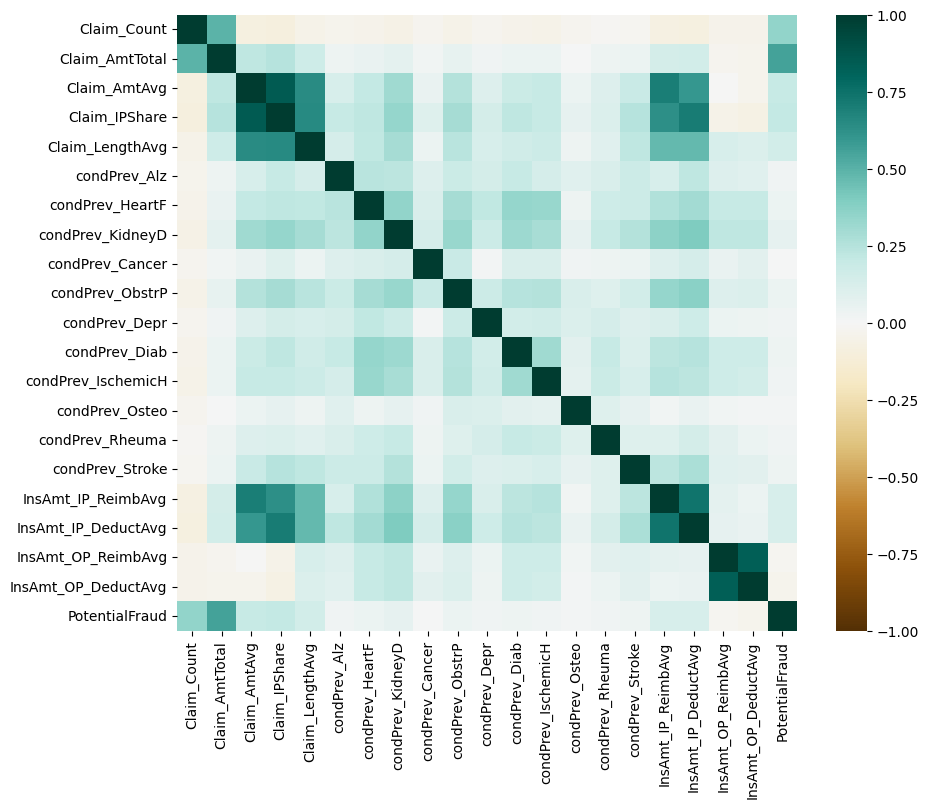

In [ ]:
corrs = df_train.corr()

fig, ax = plt.subplots(figsize=(10, 8))

plot = sns.heatmap(corrs, vmin = -1, vmax = 1,
                   cmap="BrBG", annot=False, ax=ax)
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)
plt.show()

##### **Discussion**

Following are my four main findings from this heatmap:

###### **(1)**
There appears to be a cluster of attributes that are all either moderately or strongly intercorrelated:
  - Average claim amount, *Claim_AmtAvg*.
  - Share of inpatient claims, *Claim_IPShare*.
  - Average claim length, *Claim_LengthAvg*.
  - Average inpatient annual reimbursement amount, *InsAmt_IP_ReimbAvg*.
  - Average inpatient annual deductible amount, *InsAmt_IP_DeductAvg*.

It strikes me that all of these attributes might be strongly related to inpatient matters. This even goes for the two attributes that might not nominally reflect those ties, like *AvgClaimLength* and *AvgClaimAmt*.

To speculate on how these latter two might relate to inpatients: higher claim lengths might correspond to longer hospital stays, which might mostly consist of inpatient admissions. And stays get costlier as they lengthen, as might the claim amounts.


###### **(2)**
The average annual amounts for reimbursements and deductibles for a given patient type are highly correlated, for both the inpatient and outpatients types.


###### **(3)**
*Claim_AmtTotal* and *Claim_Count* are moderately correlated to each other and also to the target, *PotentialFraud*. The former correlation is expected, but still worth noting. In fact, if those two predictors are correlated strongly enough, I might well omit *Claim_Count* in a scenario of correlation-based feature selection.

###### **(4)**
*PotentialFraud* appears to be weakly correlated to both the chronic condition prevalence attributes (those starting with *condPrev_*) and the outpatient insurance amount attributes (those two starting with *InsAmt_OP*.)

#### **Correlations to the Target**

In [ ]:
# Listing the absolute values of predictors' correlations to the target, in
# descending order.
abs(corrs['PotentialFraud'])[:-1].sort_values(ascending=False)

,PotentialFraud
Claim_AmtTotal,0.560134
Claim_Count,0.346966
Claim_IPShare,0.207715
Claim_AmtAvg,0.202383
Claim_LengthAvg,0.155963
InsAmt_IP_ReimbAvg,0.129567
InsAmt_IP_DeductAvg,0.126248
condPrev_KidneyD,0.068940
condPrev_ObstrP,0.046740
condPrev_HeartF,0.042842


##### **Discussion**

The two highest correlations to the target attribute *PotentialFraud* are those of *Claim_AmtTotal* and *Claim_Count*, which show 0.5601 and 0.3470, respectively.

The rest of the attributes have fairly weak correlations to the target, though five of their's range between 0.12 and 0.21.

This table underscores the fourth finding from the previous sections, that the target correlations of the chronic condition and outpatient insurance attributes are uniformly very low. They are low enough that, in a correlation-based feature selection, I would omit them all.

#### **Identifying the higher correlations between predictors**

In correlation-based feature selection, if any predictors are too strongly intercorrelated, then one or more of them should be omitted.

In this subsection, I set a correlation threshold at 0.4 and programmatically identify the intercorrelations that surpass it.

##### **Function for identifying high correlations**

Instead of manually searching for high correlations in the expansive result of a `pandas.DataFrame.corr()` call, I here define a function to identify them programmatically.

Much of its code comes from a *Medium.com* contributor **Yatharth Ranjan**, who featured it in a piece, linked here:
https://medium.com/@yatharthranjan/finding-top-correlation-pairs-from-a-large-number-of-variables-in-pandas-f530be53e82a

I have made some additions to it, mainly the heatmap that visualizes only the predictors that have at least one correlation above the threshold. I also altered the function so that it no longer returns a table of the exceeding correlations, but instead prints them uniquely in descending order.

In the code cell following this function's definition, I call it to identify the predictor correlations that exceed `0.4`.

In [ ]:
def get_high_corrs(df, threshold=0.4):
  i = 0
  pairs = set()
  result = pd.DataFrame()
  orig_corr = df.corr()
  c = orig_corr.abs()
  so = c.unstack()

  high_corr_attrs = set()

  print(f'UNIQUE CORRELATIONS EXCEEDING {threshold}',
        f', sorted by correlation value:\n')
  print(f'PAIR{" "*53}CORRELATION VALUE')
  for index, value in so.sort_values(ascending=False).items():
      if value > threshold \
      and index[0] != index[1] \
      and (index[0], index[1]) not in pairs \
      and (index[1], index[0]) not in pairs:
          high_corr_attrs.add(index[0])
          high_corr_attrs.add(index[1])
          alpha_sorted_pair = sorted([index[0], index[1]])
          pairs.add(index)
          result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = [alpha_sorted_pair[0], alpha_sorted_pair[1], orig_corr.loc[(index[0], index[1])]]
          i += 1
          og_value = orig_corr.loc[(alpha_sorted_pair[0], alpha_sorted_pair[1])]
          formatted_attribute_pair = f'{alpha_sorted_pair[0]} & {alpha_sorted_pair[1]}'
          attr_pair_str_len = len(formatted_attribute_pair)
          print_buffer = (56 - attr_pair_str_len) * ' '
          print(f'{formatted_attribute_pair}:{print_buffer}{round(og_value, 4)}')
  print('\n')

  high_corr_attrs = sorted(list(high_corr_attrs))
  high_corr_df = df[high_corr_attrs].corr()[df[high_corr_attrs].corr().abs() > 0.4]

  # # Print the unstacked (and non-unique) correlations exceeding the threshold
  # print(f'NON-UNIQUE CORRELATIONS EXCEEDING {threshold}, ',
  #       f'sorted by attribute name:\n')
  # print(high_corr_df[high_corr_df != 1].unstack().dropna().sort_index())

  # Plotting a correlation heatmap of only these attributes which show at least
  # one intercorrelation higher than the threshold.
  sns.heatmap(high_corr_df, vmin = -1, vmax = 1, cmap="BrBG", annot=True)
  plt.title(f"Predictor Intercorrelations Exceeding {threshold}")
  plt.show()



UNIQUE CORRELATIONS EXCEEDING 0.4 , sorted by correlation value:

PAIR                                                     CORRELATION VALUE
Claim_AmtAvg & Claim_IPShare:                            0.8462
InsAmt_OP_DeductAvg & InsAmt_OP_ReimbAvg:                0.8313
InsAmt_IP_DeductAvg & InsAmt_IP_ReimbAvg:                0.7419
Claim_IPShare & InsAmt_IP_DeductAvg:                     0.7068
Claim_AmtAvg & InsAmt_IP_ReimbAvg:                       0.7014
Claim_IPShare & Claim_LengthAvg:                         0.6493
Claim_AmtAvg & Claim_LengthAvg:                          0.646
Claim_IPShare & InsAmt_IP_ReimbAvg:                      0.6269
Claim_AmtAvg & InsAmt_IP_DeductAvg:                      0.5978
Claim_AmtTotal & Claim_Count:                            0.4992
Claim_LengthAvg & InsAmt_IP_DeductAvg:                   0.4752
Claim_LengthAvg & InsAmt_IP_ReimbAvg:                    0.4746
InsAmt_IP_DeductAvg & condPrev_KidneyD:                  0.4032




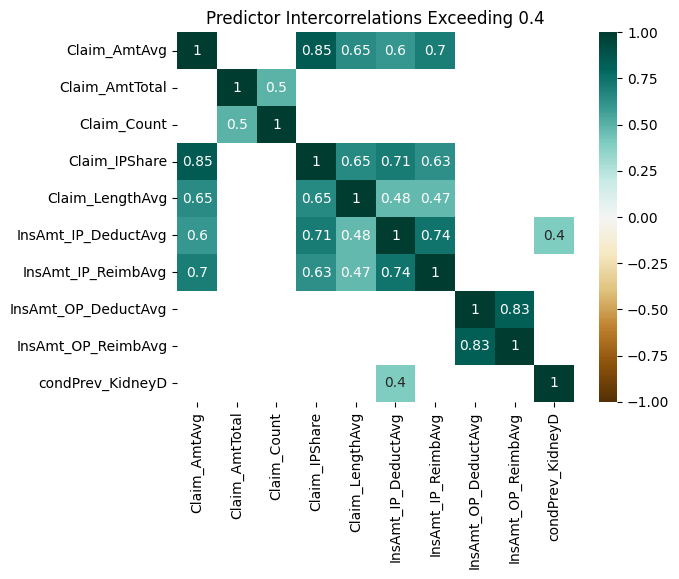

In [ ]:
get_high_corrs(X_train)

### **Correlation-Based Feature Selection (CFS)**

Using the above findings, I will now manually perform correlation-based feature selection. This involves the inclusion or exclusion of attributes based on the following dual objectives:
  1. Keeping in features that are highly correlated to the target.
  2. Removing features that are highly correlated to others.

For helpful reference for this process, I am again listing the predictors' correlations to the target:

In [ ]:
corrs['PotentialFraud'][:-1].sort_values(ascending=False)

,PotentialFraud
Claim_AmtTotal,0.560134
Claim_Count,0.346966
Claim_IPShare,0.207715
Claim_AmtAvg,0.202383
Claim_LengthAvg,0.155963
InsAmt_IP_ReimbAvg,0.129567
InsAmt_IP_DeductAvg,0.126248
condPrev_KidneyD,0.068940
condPrev_ObstrP,0.046740
condPrev_HeartF,0.042842


#### **Feature Removal I**: Low correlation with target

I am removing the following features because their correlations to the target are too low:
  - All chronic condition features (which are those with prefix *condPrev_*.)

  - The outpatient annual insurance amounts, *InsAmt_OP_ReimbAvg* and *InsAmt_OP_DeductAvg*.

Implementing this feature selection in a temporary dataframe `df_cbfs_1`:

In [ ]:
condprev_attrs = [x for x in df_train.columns if 'condPrev_' in x]
low_corr_attrs = condprev_attrs + ['InsAmt_OP_ReimbAvg', 'InsAmt_OP_DeductAvg']

df_cbfs_1 = df_train.drop(low_corr_attrs, axis=1)

#### **Reexamining the remaining correlations**

Having removed numerous features in the previous step, I return to analysis by reviewing the intercorrelations of the remaining features:

In [ ]:
corr_cbfs_1 = df_cbfs_1.corr()

Re-printing correlations to the target for these remaining attributes, in descending order:

In [ ]:
corr_cbfs_1['PotentialFraud'][:-1].sort_values(ascending=False)

,PotentialFraud
Claim_AmtTotal,0.560134
Claim_Count,0.346966
Claim_IPShare,0.207715
Claim_AmtAvg,0.202383
Claim_LengthAvg,0.155963
InsAmt_IP_ReimbAvg,0.129567
InsAmt_IP_DeductAvg,0.126248


Calling my `get_high_corrs` method to identify any groups of significantly correlated variables:

UNIQUE CORRELATIONS EXCEEDING 0.4 , sorted by correlation value:

PAIR                                                     CORRELATION VALUE
Claim_AmtAvg & Claim_IPShare:                            0.8462
InsAmt_IP_DeductAvg & InsAmt_IP_ReimbAvg:                0.7419
Claim_IPShare & InsAmt_IP_DeductAvg:                     0.7068
Claim_AmtAvg & InsAmt_IP_ReimbAvg:                       0.7014
Claim_IPShare & Claim_LengthAvg:                         0.6493
Claim_AmtAvg & Claim_LengthAvg:                          0.646
Claim_IPShare & InsAmt_IP_ReimbAvg:                      0.6269
Claim_AmtAvg & InsAmt_IP_DeductAvg:                      0.5978
Claim_AmtTotal & PotentialFraud:                         0.5601
Claim_AmtTotal & Claim_Count:                            0.4992
Claim_LengthAvg & InsAmt_IP_DeductAvg:                   0.4752
Claim_LengthAvg & InsAmt_IP_ReimbAvg:                    0.4746




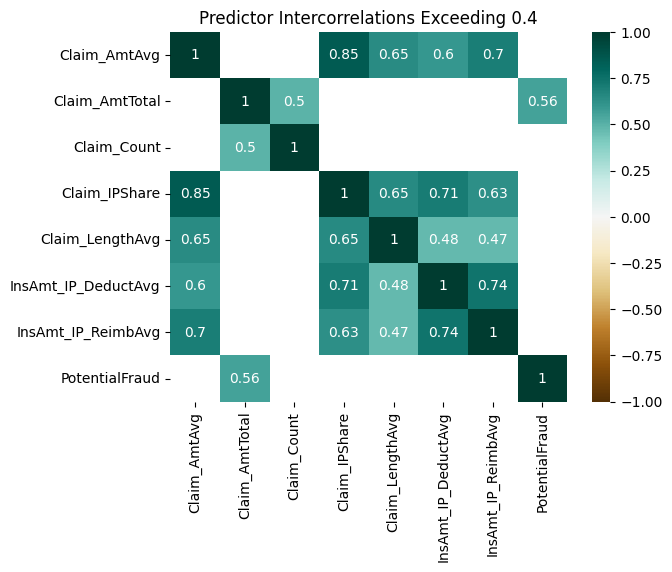

In [ ]:
get_high_corrs(df_cbfs_1)

#### **Feature Removal II: Considering high intercorrelations**

I am removing the following predictor attributes because the inflational cost of their high correlation with another predictor outweighs the informational benefit of their correlation to the target:

  - ***Claim_AmtAvg***:

    Highly or moderately correlated to *Claim_IPShare*, *InsAmt_IP_ReimbAvg*, and *Claim_LengthAvg*, while being inferior to the first of these in correlation to the target.
   
  - ***InsAmt_IP_DeductAvg*** and ***InsAmt_IP_ReimbAvg***:

    Both are moderately correlated to *Claim_IPShare* while substantially less correlated to the target than the latter. Also, these are highly correlated to each other.

  - ***Claim_LengthAvg***:
      
    Moderately correlated to fellow predictor *Claim_IPShare* while having slightly lesser correlation to the target.

  - ***Claim_Count***
  
    Omitting this attribute was a difficult decision, as it shows the second highest correlation to the target. However, its correlation to *Claim_AmtTotal* is high enough that I am opting to exclude it.



**Eliminating these variables will result in my final CFS-reduced dataset `df_CFS`:**

In [ ]:
df_CFS = df_cbfs_1.drop(['Claim_AmtAvg', 'InsAmt_IP_DeductAvg',
                         'InsAmt_IP_ReimbAvg', 'Claim_LengthAvg', 'Claim_Count'],
                         axis=1)
df_CFS.corr()

,Claim_AmtTotal,Claim_IPShare,PotentialFraud
Claim_AmtTotal,1.000000,0.248356,0.560134
Claim_IPShare,0.248356,1.000000,0.207715
PotentialFraud,0.560134,0.207715,1.000000


My manual CFS process has yielded a dataset with only two predictors, which respectively represent providers' claim amount totals and the shares of their claims that were for inpatients.

<a name="exploratory-visualization"></a>
### **Visualization**

#### *Do attributes' distributions differ considerably by the target's state?*

I am now putting aside this reduced dataset `df_CFS` that I formed in the previous section, and returning to the fully-featured one from just earlier, `df_train`.

Now, by leveraging techniques of data visualization, I will now try to identify which predictors might distribute very differently between the two states of the target, _PotentialFraud_. This might shed more light on the attributes' informative value, in addition to the correlation analysis just conducted.

To compare how an attribute distributes differently depending on its _PotentialFraud_ status, I will visualize in small multiples of violin plots.

#### **Claim Attributes**

My first set of violin plots focuses on the attributes that relate to claim information.

I have named such attributes to contain the substring of 'Claim' or 'Clm', and thusly identify them:

In [ ]:
clm_flds = [x for x in df_train.columns.tolist() if 'Claim' in x or 'Clm' in x]
clm_flds

['Claim_Count',
 'Claim_AmtTotal',
 'Claim_AmtAvg',
 'Claim_IPShare',
 'Claim_LengthAvg']

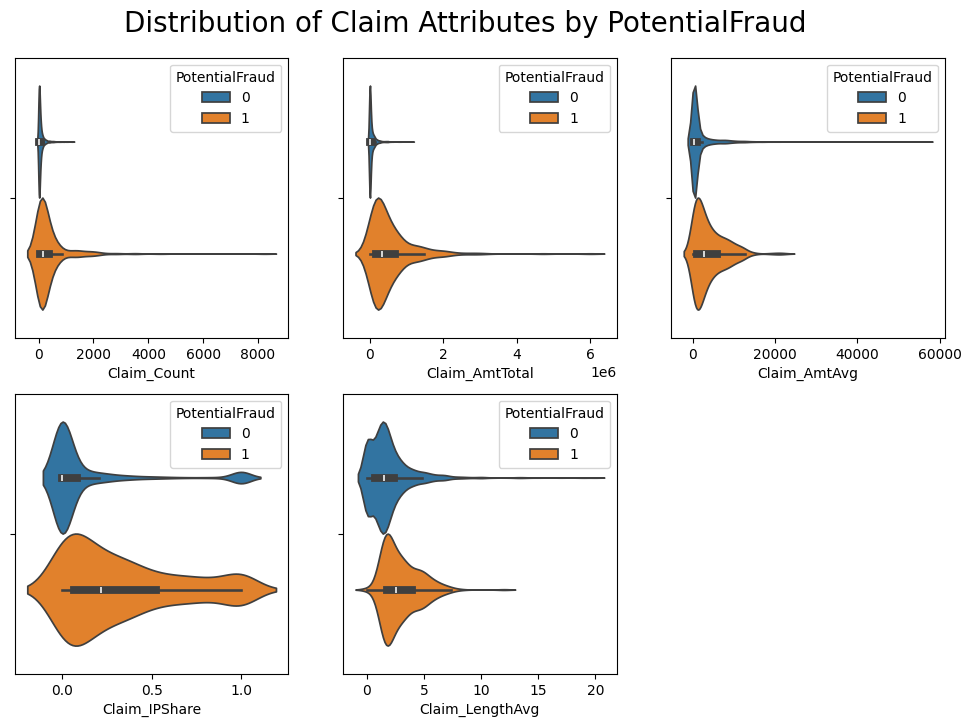

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.suptitle('Distribution of Claim Attributes by PotentialFraud', fontsize=20, y=0.94)
sns.violinplot(df_train, x =clm_flds[0], hue='PotentialFraud', ax=axs[0][0])
sns.violinplot(df_train, x =clm_flds[1], hue='PotentialFraud', ax=axs[0][1])
sns.violinplot(df_train, x =clm_flds[2], hue='PotentialFraud', ax=axs[0][2])
sns.violinplot(df_train, x =clm_flds[3], hue='PotentialFraud', ax=axs[1][0])
sns.violinplot(df_train, x =clm_flds[4], hue='PotentialFraud', ax=axs[1][1])
axs[-1,-1].axis('off')
plt.show()


One attribute here struck me immediately as having the highest-contrasting distributions between potential fraud states: *Prv_Claim_IPShare*. Most of these attributes' unfraudulent distributions are both concentrated around lower values and fairly symmetrical, excepting the sparse tails.

But the distribution of *Prv_Claim_IPShare* for the potentially fraud cases isn't symmetrical at all. And it swells far past its unfraudulent counterpart, with much support throughout that extension.

This phenomenon might support what was determined in the preceding correlation analysis: *Prv_Claim_IPShare* might be an especially important feature in identifying _PotentialFraud_ status.

Furthermore, the attributes for claim count, total amount, and average amount (featured in the top row, left to right) appear to also be strongly indicative of potential fraudulence. Their distributions of potentially fraud cases are much more skewed towards higher amounts than the those of the unfraudulent distributions.

This might bolster another finding from the correlation analysis: the predictive potential of the *Claim_AmtTotal* attribute.

#### **Chronic Condition Attributes**

My next two sets of violin plots focus on the chronic condition attributes. These represent the percentage-wise prevalence of a given chronic condition amongst a provider's patients.

I have named such attributes to contain the substring of 'condPrev_', and thusly identify them:

In [ ]:
chronCond = [x for x in df_train.columns.tolist() if 'condPrev_' in x]
chronCond

['condPrev_Alz',
 'condPrev_HeartF',
 'condPrev_KidneyD',
 'condPrev_Cancer',
 'condPrev_ObstrP',
 'condPrev_Depr',
 'condPrev_Diab',
 'condPrev_IschemicH',
 'condPrev_Osteo',
 'condPrev_Rheuma',
 'condPrev_Stroke']

There are as many as eleven of these attributes, so I break these into two subsequent visualizations:

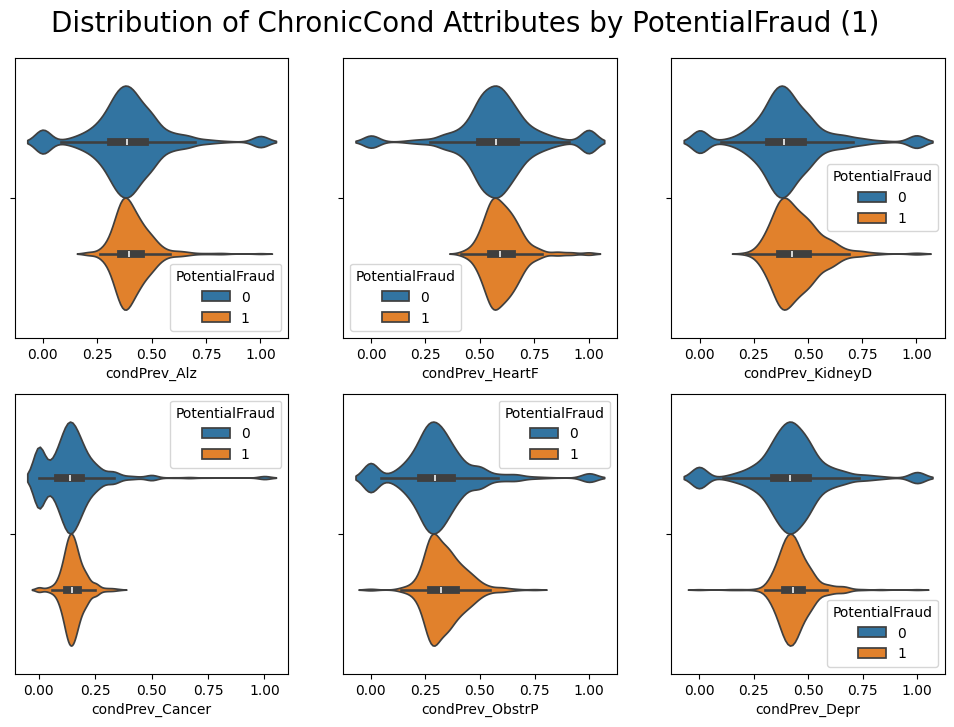

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.suptitle('Distribution of ChronicCond Attributes by PotentialFraud (1)', fontsize=20, y=0.94)
sns.violinplot(df_train, x =chronCond[0], hue='PotentialFraud', ax=axs[0][0])
sns.violinplot(df_train, x =chronCond[1], hue='PotentialFraud', ax=axs[0][1])
sns.violinplot(df_train, x =chronCond[2], hue='PotentialFraud', ax=axs[0][2])
sns.violinplot(df_train, x =chronCond[3], hue='PotentialFraud', ax=axs[1][0])
sns.violinplot(df_train, x =chronCond[4], hue='PotentialFraud', ax=axs[1][1])
sns.violinplot(df_train, x =chronCond[5], hue='PotentialFraud', ax=axs[1][2])
plt.show()


The main discrepancies that I'm interpreting here are that the unfraudulent distributions are substantially populated at their extremes, while the potentially fraudulent ones are not.

Aside from that, the distribution shapes appear to me as pretty similar. I wonder if this might support the correlation analysis' determination that these chronic condition attributes might not be useful in identifying potential fraudulence.

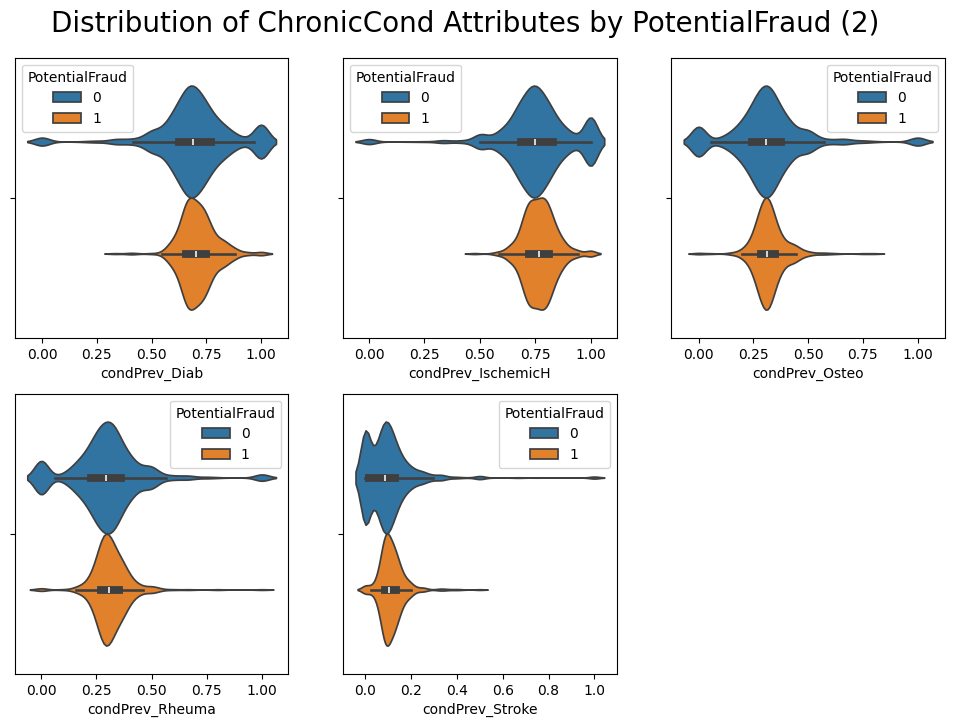

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.suptitle('Distribution of ChronicCond Attributes by PotentialFraud (2)', fontsize=20, y=0.94)
sns.violinplot(df_train, x =chronCond[6], hue='PotentialFraud', ax=axs[0][0])
sns.violinplot(df_train, x =chronCond[7], hue='PotentialFraud', ax=axs[0][1])
sns.violinplot(df_train, x =chronCond[8], hue='PotentialFraud', ax=axs[0][2])
sns.violinplot(df_train, x =chronCond[9], hue='PotentialFraud', ax=axs[1][0])
sns.violinplot(df_train, x =chronCond[10], hue='PotentialFraud', ax=axs[1][1])
axs[-1,-1].axis('off')
plt.show()


These last five attributes' distributions are consistent with the pattern found just previously, for the first six: the unfraudulent distributions tend to have substantial support on the extreme ends, while the potentially fraudulent ones do not.

#### **Average Annual Insurance Coverage Attributes**

My last set of violin plots focuses on the average annual reimbursements and deductibles of a provider's patients. These are measured separately for inpatients (IP) and outpatients (OP.)

I have named such attributes to contain the substring of 'InsAmt_', and thusly identify them:

In [ ]:
list(df_train.columns)

['Claim_Count',
 'Claim_AmtTotal',
 'Claim_AmtAvg',
 'Claim_IPShare',
 'Claim_LengthAvg',
 'condPrev_Alz',
 'condPrev_HeartF',
 'condPrev_KidneyD',
 'condPrev_Cancer',
 'condPrev_ObstrP',
 'condPrev_Depr',
 'condPrev_Diab',
 'condPrev_IschemicH',
 'condPrev_Osteo',
 'condPrev_Rheuma',
 'condPrev_Stroke',
 'InsAmt_IP_ReimbAvg',
 'InsAmt_IP_DeductAvg',
 'InsAmt_OP_ReimbAvg',
 'InsAmt_OP_DeductAvg',
 'PotentialFraud']

In [ ]:
pat_ins_amt_attrs = [x for x in df_train.columns.tolist() if 'InsAmt_' in x]
pat_ins_amt_attrs

['InsAmt_IP_ReimbAvg',
 'InsAmt_IP_DeductAvg',
 'InsAmt_OP_ReimbAvg',
 'InsAmt_OP_DeductAvg']

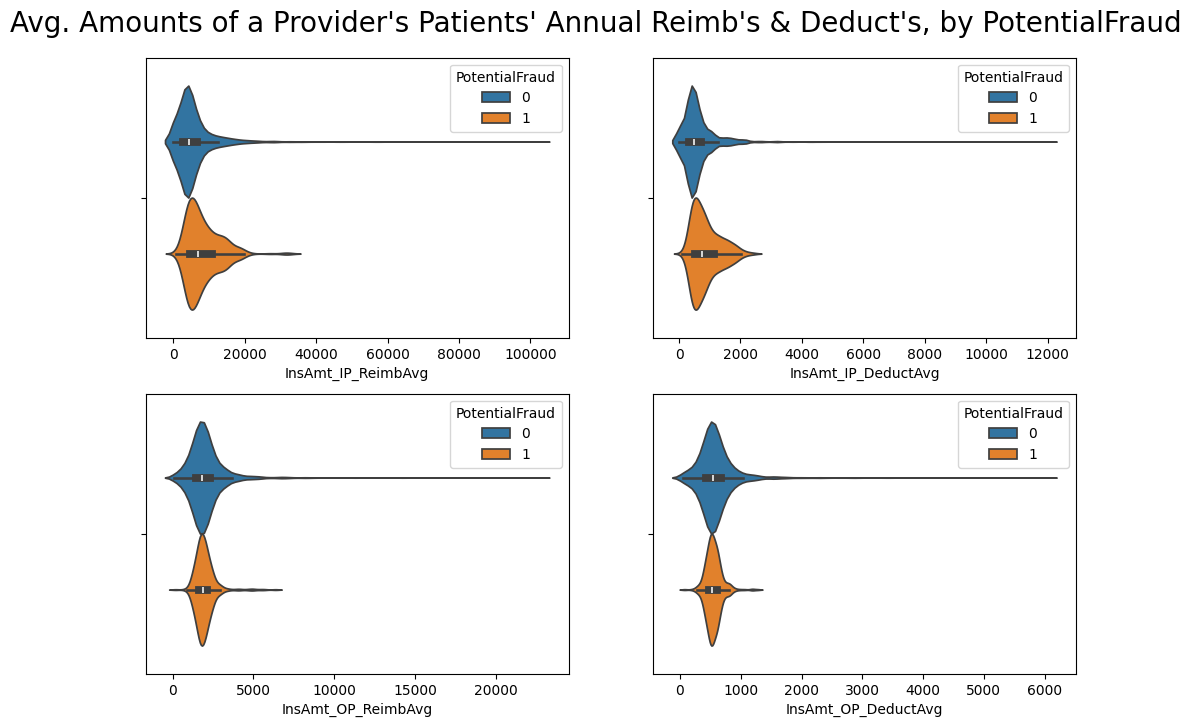

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Avg. Amounts of a Provider's Patients' Annual Reimb's & Deduct's, by PotentialFraud", fontsize=20, y=0.94)
sns.violinplot(df_train, x =pat_ins_amt_attrs[0], hue='PotentialFraud', ax=axs[0][0])
sns.violinplot(df_train, x =pat_ins_amt_attrs[1], hue='PotentialFraud', ax=axs[0][1])
sns.violinplot(df_train, x =pat_ins_amt_attrs[2], hue='PotentialFraud', ax=axs[1][0])
sns.violinplot(df_train, x =pat_ins_amt_attrs[3], hue='PotentialFraud', ax=axs[1][1])
plt.show()


I am interpreting discrepancies in the distributions of *InsAmt_IP_ReimbAvg* and *InsAmt_IP_DeductAvg*, though they are subtle ones. These inpatient attributes' distributions for the potentially fraud providers swell substantially on the right side of the shape, where higher amounts are represented. These contrast with the distribution shapes of their unfraudulent counterparts, which are more symmetrical and bell-curved.

Another difference is that the unfraudulent distributions have much longer tails on the right side, extending to far higher amounts. However, I'm reluctant to interpret much significance from this, as those tails are very sparsely populated.

<a name="resampling"></a>
## **Creating the Various Samples**

One primary goal of this analysis was to explore whether differing feature selections and sampling techniques might aid classification, specifically in the context of healthcare claim fraud.

To this end, I am creating three datasets:

1. The conventionally split random sample (which already exist as my current working df's, used in my EDA just previous.)
2. A version of (1) that has had its class imbalance reduced, by oversampling from the minority class.
3. A version of (2) reduced through the application of my Correlation-based Feature Selection (CFS). This involves retaining only the attributes *Claim_AmtTotal* and *Claim_IPShare*.

### **Conventional Sample**

As mentioned, the conventional sample is merely the current working datasets, `X_train` and `y_train`. These were created towards the end of section "Data Integration II," by splitting the available data 80-20 for train and test.

For reference, I copy the command that created these sets, commented-out:

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2,
#                                                     stratify=y_all,
#                                                     random_state=rand_st)

In [ ]:
X_train_cs = X_train.copy()
y_train_cs = y_train.copy()

X_test_cs = X_test.copy()
y_test_cs = y_test.copy()

Reviewing the shape of these datasets:

In [ ]:
print(f'{X_train_cs.shape=}', f'{y_train.shape=}', '\n',
      f'{X_test_cs.shape=}', f'{y_test_cs.shape=}',
      sep = '\n')

X_train_cs.shape=(4328, 20)
y_train.shape=(4328,)


X_test_cs.shape=(1082, 20)
y_test_cs.shape=(1082,)


Examining the class balance of this conventionally split sample:

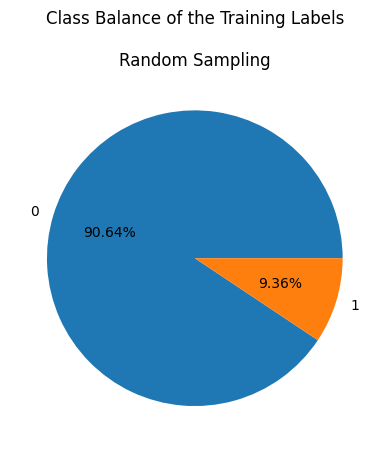

In [ ]:
pie_keys = y_train.value_counts().index.tolist()
pie_vals = y_train.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Training Labels\n\nRandom Sampling')
plt.show()

Roughly 91% of the providers in this training data show '0' for _PotentialFraud_, with only 9% showing '1'. This is a degree of class imbalance that can create issues for classification. Models trained on imbalanced data tend to bias their classification in favor of the more prevalent state.

In the section shortly following, I will create a more balanced sample for training, using a technique called oversampling.

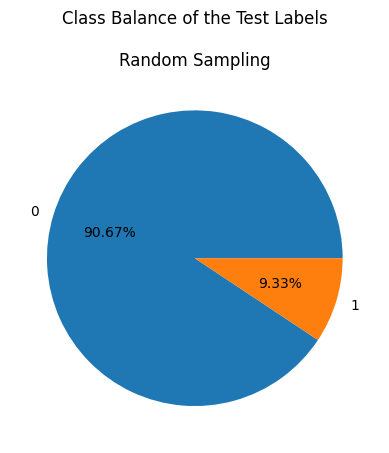

In [ ]:
pie_keys = y_test.value_counts().index.tolist()
pie_vals = y_test.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Test Labels\n\nRandom Sampling')
plt.show()

The stratified sampling appears to have been successful, as the class balance is highly similar between the training and test sets.

Save these datasets to files, for future reference and reproducibility.

In [ ]:
path_to_data_dir = '/content/gdrive/MyDrive/fraud_data_dsc540/data/preprocessed/'

# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/cs'

!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_cs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_cs.csv')
y_train_cs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_cs.csv')
X_test_cs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_cs.csv')
y_test_cs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_cs.csv')

# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/cs'

!mkdir -p {path_to_data_dir}{sample_file_dirpath_suffix}

X_train_cs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_cs.pkl')
y_train_cs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_cs.pkl')
X_test_cs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_cs.pkl')
y_test_cs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_cs.pkl')

### **Conventional + CFS Sample**
#### Applying CFS to the conventionally-sampled set

In the subsection of my correlation analysis titled "Correlation-Based Feature Selection," I arrived at a selection of only two predictors. These were *Claim_AmtTotal* and *Claim_IPShare*.

For reference, I print these below as columns of that set, alongside that of the target, _PotentialFraud_:

In [ ]:
print(df_CFS.columns.tolist())

['Claim_AmtTotal', 'Claim_IPShare', 'PotentialFraud']


Next, I apply the reduction of this CFS to the data by taking the corresponding subset of attributes:

In [ ]:
# The CFS-reduced data is selected from the rebalanced, 75:25 dataset.
X_train_cs_cfs = X_train_cs[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The training labels are unchanged
y_train_cs_cfs = y_train_cs.copy()

# Glancing at this reduced training data
X_train_cs_cfs.head()

,Claim_AmtTotal,Claim_IPShare
3090,25220,0.000000
3462,8320,0.000000
3446,36470,0.000000
839,148550,0.625000
921,454360,0.534091


The feature selection must also be applied to the test subset of the predictor data, while the test labels again remain the same:

In [ ]:
# Create the test predictor dataset
X_test_cs_cfs = X_test_cs[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The test labels are unchanged.
y_test_cs_cfs = y_test_cs.copy()

I save these datasets to file, for future reference and reproducibility:

In [ ]:
# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/cs_cfs'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_cs_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_cs_cfs.csv')
y_train_cs_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_cs_cfs.csv')
X_test_cs_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_cs_cfs.csv')
y_test_cs_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_cs_cfs.csv')

# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/cs_cfs'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_cs_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_cs_cfs.pkl')
y_train_cs_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_cs_cfs.pkl')
X_test_cs_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_cs_cfs.pkl')
y_test_cs_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_cs_cfs.pkl')

### **Rebalanced Sample**
#### Addressing Class Imbalance

I now create a sample with better class balance. I seek to achieve 75-25 split (75% unfraudulent cases, 25% potentially fraud.) This ratio has been recommended as good starting point for rebalancing efforts.

First, for my own information, I do a little math to determine how many cases will need to be resampled from the minority class in order to achieve a 75-25 ratio:

In [ ]:
potential_fraud_cases = y_train_cs.value_counts()
print(f'Cases where "PotentiallyFraud == 0": {potential_fraud_cases[0]}')
print(f'Cases where "PotentiallyFraud == 1": {potential_fraud_cases[1]}')
print(f'\nNumber of "PotentiallyFraud == 1" cases needed for 75-25 balance: {potential_fraud_cases[0]/3}')
print(f'Number of resampled cases necessary to achieve that: {(potential_fraud_cases[0]/3) - potential_fraud_cases[1]}')

Cases where "PotentiallyFraud == 0": 3923
Cases where "PotentiallyFraud == 1": 405

Number of "PotentiallyFraud == 1" cases needed for 75-25 balance: 1307.6666666666667
Number of resampled cases necessary to achieve that: 902.6666666666667


To reach the desired balance, it will take approximately 900 oversampled cases of potential fraudulence. This is more than double the number of such records that are authentic, which is 405.

So after resampling, more than two thirds of the "PotentialFraud == 1" cases will be synthetically produced. This is a heavy bias that will be important to consider when discussing results later on.

Carrying out the resampling:

In [ ]:
ros = RandomOverSampler(sampling_strategy=(1/3), random_state=rand_st)

X_train_os, y_train_os = ros.fit_resample(X_train_cs, y_train_cs)

Resampling is only performed on the data used to train the models.

The test data is left alone, but I will copy it for clarity, like I did in the previous sample:

In [ ]:
X_test_os = X_test_cs.copy()
y_test_os = y_test_cs.copy()

Reviewing the shape of these datasets:

In [ ]:
print(f'{X_train_os.shape=}', f'{y_train_os.shape=}', '\n',
      f'{X_test_cs.shape=}', f'{y_test_cs.shape=}',
      sep = '\n')

X_train_os.shape=(5230, 20)
y_train_os.shape=(5230,)


X_test_cs.shape=(1082, 20)
y_test_cs.shape=(1082,)


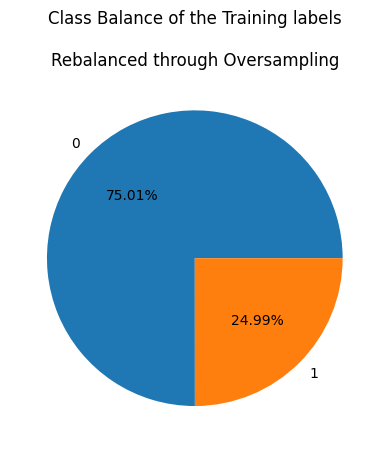

In [ ]:
pie_keys = y_train_os.value_counts().index.tolist()
pie_vals = y_train_os.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Training labels\n\nRebalanced through Oversampling')
plt.show()

The oversampling appears to have been successful. With that done, I will commence the next round of modelling.

Saving these datasets to files, for future reference and reproducibility:

In [ ]:
# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/os'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_os.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_os.csv')
y_train_os.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_os.csv')
X_test_os.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_os.csv')
y_test_os.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_os.csv')

# Savings this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/os'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_os.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_os.pkl')
y_train_os.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_os.pkl')
X_test_os.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_os.pkl')
y_test_os.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_os.pkl')

### **Rebalanced + CFS Sample**
#### Applying CFS to the rebalanced set

In the subsection of my correlation analysis titled "Correlation-Based Feature Selection," I arrived at only two features.

For reference, I re-print those attributes (and also the target, _PotentialFraud_):

In [ ]:
print(df_CFS.columns.tolist())

['Claim_AmtTotal', 'Claim_IPShare', 'PotentialFraud']


Next, I create the CFS-reduced data by taking the corresponding attribute subset of the existing oversampled data (from the previous section):

In [ ]:
# The CFS-reduced data is selected from the rebalanced, 75:25 dataset.
X_train_os_cfs = X_train_os[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The training labels are unchanged
y_train_os_cfs = y_train_os.copy()

# Glancing at this reduced, oversampled training data
X_train_os_cfs.head()

,Claim_AmtTotal,Claim_IPShare
0,25220,0.000000
1,8320,0.000000
2,36470,0.000000
3,148550,0.625000
4,454360,0.534091


The feature selection must also be applied to the test set of predictor data, while the test labels again remain the same:

In [ ]:
# Create the test predictor dataset
X_test_os_cfs = X_test_os[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The test labels are unchanged.
y_test_os_cfs = y_test_os.copy()

Saving these datasets to files, for future reference and reproducibility:

In [ ]:
# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/os_cfs'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_os_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_os_cfs.csv')
y_train_os_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_os_cfs.csv')
X_test_os_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_os_cfs.csv')
y_test_os_cfs.to_csv(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_os_cfs.csv')

# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/os_cfs'
!mkdir -p {path_to_data_dir + sample_file_dirpath_suffix}

X_train_os_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_train_os_cfs.pkl')
y_train_os_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_train_os_cfs.pkl')
X_test_os_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/X_test_os_cfs.pkl')
y_test_os_cfs.to_pickle(path_to_data_dir + sample_file_dirpath_suffix + '/y_test_os_cfs.pkl')

<a name="modelling"></a>
## **Modelling**
### **Approach**

A primary objective of this analysis is to explore and test recommendations from the literature I consulted. One such recommendation was to use ensemble learning methods for claim fraud classification, as those methods might here be especially suitable.

To test this in my modelling, I will use three such ensemble methods alongside two non-ensemble ones. Specifically, I will use the following techniques to fit gridsearches on each of my four samples:
1. Random Forest
2. Gradient Boosting
3. Ada Boosting
4. Naive Bayes
5. SVM

These combinations of learning method and sample thus total to twenty hypertunings. (5 methods * 4 samples.) To execute this hypertuning iteratively, I define a function to handle each run. The function produces both a fitted `gridsearchCV` object and a record of validation results, suitable for entry into a table also defined below.

Once training validation is thusly completed for all of the methods and samples, I will conduct test validation in a similar fashion.

### **Training**

As I mention above, I am running twenty gridsearches to arrive at as many trained models. In my experience, when training so many models in a notebook, it can be challenging to maintain consistency and organization throughout.

To mitigate those challenges, I find it helpful to automate both the processing and the result-logging as much as is reasonably possible.

#### **Setup**

##### **Table for training validation results**

I store the training validation record output in the following dataframe:

In [ ]:
# Empty dataframe to store the training validation results.
train_results_df = pd.DataFrame({'ML Method':[],
                               'Class Balance':[],
                               'Sampling Technique':[],
                               'Feature Selection':[],
                                   'Hypertuning Runtime':[],
                                   'Training Precision':[],
                                   'Training Accuracy':[],
                                   'Training Recall':[],
                                   'Training F1':[],
                                   'Estimators':[],
                                   'Criterion':[],
                                   'Loss':[],
                                   'Max Depth':[],
                                   'Min Samples Split':[],
                                   'Learning Rate':[]
                                   })
train_results_df.T

""
ML Method
Class Balance
Sampling Technique
Feature Selection
Hypertuning Runtime
Training Precision
Training Accuracy
Training Recall
Training F1
Estimators


##### **Parameter Grids**

I will use the following parameter grids for each learning method's hypertuning, regardless of sample:

In [ ]:
# Random Forest parameter grid
rf_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 7],
}

# Gradient Boosting parameter grid
gb_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'max_depth': [3, 7],
    'learning_rate': [1, 0.1]
}

# Ada Boosting parameter grid
ab_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'learning_rate': [1, 0.1]
}

# Naive Bayes parameter grid
nb_param_grid = {
    'var_smoothing': np.logspace(-8, -10, num=3)
}

# SVM parameter grid
svm_param_grid = {
    'C': [1.0, 0.1, 0.01],
    'kernel': ['rbf']
    }

##### **Dictionary for `gridsearchCV` objects**

Because some of the hypertuning runs of this work take a long time to process, I store the fitted `gridsearchCV` objects in a dictionary that is eventually saved to file.

In [ ]:
gs_dict = {}

# Setting an indicator that the gridsearches should be reran. (If they should
# instead be loaded from file, run the next cell as well.)
run_the_gridsearches = True

###### **(Optional) Load previously-fitted `gridsearchCV` objects from file**

To instead load such a dictionary of fitted gridsearches from a previous run:

In [ ]:
# run_the_gridsearches = False

# dict_filepath = '/content/gdrive/MyDrive/fraud_data_dsc540/modelling_results/' + \
#                 'gridsearch_dicts/gridsearch_dict__2024-11-12__22:20.pkl'

# with open(dict_filepath, 'rb') as file:
#   gs_dict = pickle.load(file)

##### **Function Definition:**



Next, I define the function that conducts the hypertuning of my twenty method-and-sample combinations. I have coded the function to recognize the specified method and sample from a single string parameter. The function parses this string to determine the appropriate combination of method and sample, then commences hypertuning accordingly.



Before defining the function, I construct a list of its accepted specification strings:

In [ ]:
ml_method_abbrs = ['rf', 'gb', 'ab', 'nb', 'svm']
sample_abbrs = ['cs', 'cs_cfs', 'os', 'os_cfs']
all_ml_s_combos = [ml + '_' + s for s in sample_abbrs for ml in ml_method_abbrs]
all_ml_s_combos

['rf_cs',
 'gb_cs',
 'ab_cs',
 'nb_cs',
 'svm_cs',
 'rf_cs_cfs',
 'gb_cs_cfs',
 'ab_cs_cfs',
 'nb_cs_cfs',
 'svm_cs_cfs',
 'rf_os',
 'gb_os',
 'ab_os',
 'nb_os',
 'svm_os',
 'rf_os_cfs',
 'gb_os_cfs',
 'ab_os_cfs',
 'nb_os_cfs',
 'svm_os_cfs']

Given one such string indicating the learning method and sample, my function conducts the hypertuning accordingly and then returns two objects:

1. the fitted `gridsearchCV` object, and
2. a `list` to be added as a record to my `train_val_results` dataframe defined at the top of this *Setup* section. This record represents the best result of the hypertuning for the given learning method, sample dataset, and parameter grid.

Because this function references the samples' datasets as they are defined outside of its own scope, it can train models on such a dataset without taking it as a parameter. (Such referenced datasets include `X_train_cs`, `y_train_cs`, `X_train_os`, etc.) This can be a dubious design choice, and as such is important to note.

###### ***hypertune_w_named_clf_and_sample()***

In [ ]:
def hypertune_w_named_clf_and_sample(ml_and_sample_string, verbose=1, prefitted_gs=None):
  """Given a string indicating the learning method and sample, return a fitted
  gridsearch as well as a list containing data on the training validation.

  If a pre-fitted gridsearchCV object is supplied, then no fitting is done, but
  a list of its training validation will still be returned, as retrieved from
  the gridsearchCV object's attributes. (This alternative to fitting a fresh
  gridsearch was coded so that a training validation record could be
  reconstructed without rerunning a lengthy hypertuning.)"""


  ## IDENTIFY SAMPLE AND ML METHOD FROM GIVEN STRING
  clf_type_abbr, sample_abbr = ml_and_sample_string.split('_', 1)


  ## BASED ON SAMPLE, SELECT DATASETS AND NOTE SAMPLE CHARACTERISTICS

  # Choose the training datasets that correspond to the sample abbreviation
  X_train_set, y_train_set = None, None
  sample_technique, feat_select_status = None, None
  match sample_abbr:
    case 'cs':
      X_train_set = X_train_cs
      y_train_set = y_train_cs
      sample_technique = 'Conventional'
      feat_select_status = 'None'
    case 'cs_cfs':
      X_train_set = X_train_cs_cfs
      y_train_set = y_train_cs_cfs
      sample_technique = 'Conventional'
      feat_select_status = 'CFS'
    case 'os':
      X_train_set = X_train_os
      y_train_set = y_train_os
      sample_technique = 'Oversampling'
      feat_select_status = 'None'
    case 'os_cfs':
      X_train_set = X_train_os_cfs
      y_train_set = y_train_os_cfs
      sample_technique = 'Oversampling'
      feat_select_status = 'CFS'
    case _:
      raise Exception(f'ERROR: Sample not identified by abbreviation: "{sample_abbr}"')

  # Determine the class balance of this sample
  class_cnts = y_train_set.value_counts()
  total_cnt = y_train_set.shape[0]

  unfraud_proportion = class_cnts.loc[0] / total_cnt
  potentialfraud_proportion = class_cnts.loc[1] / total_cnt

  unfraud_ratio_segment = int(round(unfraud_proportion, 2) * 100)
  potentialfraud_ratio_segment = int(round(potentialfraud_proportion, 2) * 100)

  class_balance = f'{unfraud_ratio_segment}-{potentialfraud_ratio_segment}'


  ## BASED ON ML METHOD, INSTANTIATE CLASSIFIER AND SELECT PARAM_GRID

  # Determine classifier type and instantiate the corresponding clf object.
  clf_type, clf, param_grid = None, None, None
  if clf_type_abbr == 'rf':
    clf_type = 'Random Forest'
    clf = RandomForestClassifier(random_state=rand_st)
    param_grid = rf_param_grid
  elif clf_type_abbr == 'gb':
    clf_type = 'Gradient Boosting'
    clf = GradientBoostingClassifier(random_state=rand_st)
    param_grid = gb_param_grid
  elif clf_type_abbr == 'ab':
    clf_type = 'Ada Boosting'
    clf = AdaBoostClassifier(random_state=rand_st)
    param_grid = ab_param_grid
  elif clf_type_abbr == 'nb':
    clf_type = 'Naive Bayes'
    clf = GaussianNB()
    param_grid = nb_param_grid
  elif clf_type_abbr == 'svm':
    clf_type = 'SVM'
    clf = SVC()
    param_grid = svm_param_grid
  else:
    raise Exception(f'ERROR: Classifier not identified by abbreviation: "{clf_type_abbr}"')


  ## RUN A GRIDSEARCH, OR LOAD A PREVIOUS ONE

  # Get a fitted gridsearchCV object, either by freshly running one or by
  # loading a pre-fitted one.
  gs = None
  if not prefitted_gs:
    # Run a fresh gridsearch/hypertuning

    precision_scorer = make_scorer(precision_score, zero_division=0)
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc',
            'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

    gs = GridSearchCV(estimator=clf, param_grid=param_grid,
                        cv=5,
                        scoring=scorers,
                        refit='precision',
                        verbose=verbose)

    feat_sel_status_print = '' if feat_select_status=='None' else ' + ' + feat_select_status
    sample_and_feat_sel_str = sample_technique + feat_sel_status_print
    print(f'HYPERTUNING: A {clf_type} classifier on the "{sample_and_feat_sel_str}" sample')

    gs.fit(X_train_set, y_train_set)

    print('COMPLETE.', end=' ')

  else:
    # Load a previous gridsearch (if one has been passed to the function as
    # optional parameter 'prefitted_gs')
    gs = prefitted_gs[ml_and_sample_string]


  ## RETRIEVE AND RECORD METRICS FROM THE GRIDSEARCH

  # Calculate the approximate time length of the hypertuning, using the
  # gridsearch's 'mean fit time' and 'mean score time' results.
  mean_fit_time = gs.cv_results_['mean_fit_time']
  mean_score_time = gs.cv_results_['mean_score_time']
  n_splits = gs.n_splits_
  n_iter = pd.DataFrame(gs.cv_results_).shape[0]

  hypertune_runtime = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter
  print(f'Estimated runtime of this hypertuning: {round(hypertune_runtime, 2)} seconds',
        end='\n\n')

  # Log performance metrics from the gridsearch results, in a partial record
  # 'train_val_result_record'. (This and other partial records will be combined
  # to form the complete val. result record.
  gs_results = gs.cv_results_
  best_estimator_ind = np.where(gs_results['rank_test_precision'] == 1)[0][0]
  train_val_result_record = [hypertune_runtime]
  for metric in ['mean_test_precision', 'mean_test_Accuracy', 'mean_test_recall', 'mean_test_f1']:
    train_val_result_record.append(round(gs_results[metric][best_estimator_ind], 4))


  # Create 'ML method and sample details' segment of the val. result record.
  method_name_and_sample_data = [clf_type, class_balance, sample_technique,
                                 feat_select_status]


  # Create 'best parameters' segment of the train_results_df record.

  if clf_type not in ['Random Forest', 'Gradient Boosting', 'Ada Boosting']:
    param_record = ['N/A'] * 6
  else:
    hps = gs.best_estimator_.get_params()
    param_record = [hps['n_estimators'], 'N/A', 'N/A', 1, 2, 'N/A']
    if 'criterion' in hps:
      param_record[1] = hps['criterion']
    if 'loss' in hps:
      param_record[2] = hps['loss'].replace('_', ' ').title()
    elif clf_type == 'Ada Boosting':
      param_record[2] = 'Exponential Loss'
    if 'max_depth' in hps:
      param_record[3] = hps['max_depth']
    if 'min_samples_split' in hps:
      param_record[4] = hps['min_samples_split']
    if 'learning_rate' in hps:
      param_record[5] = hps['learning_rate']


  # Assemble the complete train_results_df record from the segments.
  record = method_name_and_sample_data + train_val_result_record + param_record

  # Return both the gridsearch and the record (a list.)
  return gs, record

#### **Execution**

As I explained just before the function definition preceding, I feed that hypertuning function strings that represent the desired learning method and sample for training.

For reference for the iterative hypertuning that I'm about to invoke, I here reprint that list of string arguments:

In [ ]:
# ml_method_abbrs = ['rf', 'gb', 'ab', 'nb', 'svm']
# sample_abbrs = ['cs', 'cs_cfs', 'os', 'os_cfs']
# all_ml_s_combos = [ml + '_' + s for s in sample_abbrs for ml in ml_method_abbrs]
all_ml_s_combos

['rf_cs',
 'gb_cs',
 'ab_cs',
 'nb_cs',
 'svm_cs',
 'rf_cs_cfs',
 'gb_cs_cfs',
 'ab_cs_cfs',
 'nb_cs_cfs',
 'svm_cs_cfs',
 'rf_os',
 'gb_os',
 'ab_os',
 'nb_os',
 'svm_os',
 'rf_os_cfs',
 'gb_os_cfs',
 'ab_os_cfs',
 'nb_os_cfs',
 'svm_os_cfs']

By passing these permutated specification strings to my hypertuning function, I iteratively run gridsearches for all those combinations of ML method and sample. At the time of writing, it takes ~20 minutes to complete these twenty hypertunings:

In [ ]:
run_starttime = datetime.now()

In [ ]:
# Noting the start time of this process in a string, to later append to the
# filename of the saved results.
timestamp_of_run = datetime.now().strftime("__%Y-%m-%d__%H:%M")

# Iteratively running gridsearches, saving them and a record of their results
# each time.
for index, combo in enumerate(all_ml_s_combos):
  gs_dict[combo], train_results_df.loc[index+1] = hypertune_w_named_clf_and_sample(combo, verbose=1)
  # print(train_results_df[:index+1])


HYPERTUNING: A Random Forest classifier on the "Conventional" sample
Fitting 5 folds for each of 8 candidates, totalling 40 fits
COMPLETE. Estimated runtime of this hypertuning: 86.58 seconds

HYPERTUNING: A Gradient Boosting classifier on the "Conventional" sample
Fitting 5 folds for each of 8 candidates, totalling 40 fits
COMPLETE. Estimated runtime of this hypertuning: 376.33 seconds

HYPERTUNING: A Ada Boosting classifier on the "Conventional" sample
Fitting 5 folds for each of 4 candidates, totalling 20 fits
COMPLETE. Estimated runtime of this hypertuning: 63.27 seconds

HYPERTUNING: A Naive Bayes classifier on the "Conventional" sample
Fitting 5 folds for each of 3 candidates, totalling 15 fits
COMPLETE. Estimated runtime of this hypertuning: 0.28 seconds

HYPERTUNING: A SVM classifier on the "Conventional" sample
Fitting 5 folds for each of 3 candidates, totalling 15 fits
COMPLETE. Estimated runtime of this hypertuning: 2.75 seconds

HYPERTUNING: A Random Forest classifier on th

In [ ]:
hypertuning_runtime = datetime.now() - run_starttime
print(f'Total time of this training = {hypertuning_runtime}')

Total hypertuning time = 0:26:40.153978


With the training and hypertuning of the models now complete, I review their performances. I first do so by examining the table where I've logged them, `train_results_df`.

It is ordered as the runs were, by sample and then by learning method:

In [ ]:
train_results_df

,ML Method,Class Balance,Sampling Technique,Feature Selection,Hypertuning Runtime,Training Precision,Training Accuracy,Training Recall,Training F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
1,Random Forest,91-9,Conventional,None,86.584990,0.9455,0.9150,0.0988,0.1774,400,entropy,N/A,3,2,N/A
2,Gradient Boosting,91-9,Conventional,None,376.327536,0.6874,0.9300,0.4642,0.5525,150,friedman_mse,Log Loss,3,2,0.1
3,Ada Boosting,91-9,Conventional,None,63.267877,0.8338,0.9328,0.3531,0.4955,400,N/A,Exponential Loss,1,2,0.1
4,Naive Bayes,91-9,Conventional,None,0.279961,0.5690,0.9191,0.5778,0.5729,N/A,N/A,N/A,N/A,N/A,N/A
5,SVM,91-9,Conventional,None,2.747846,0.7465,0.9295,0.3753,0.4992,N/A,N/A,N/A,N/A,N/A,N/A
6,Random Forest,91-9,Conventional,CFS,41.367405,0.8076,0.9337,0.3852,0.5207,400,entropy,N/A,3,2,N/A
7,Gradient Boosting,91-9,Conventional,CFS,69.899649,0.6698,0.9275,0.4519,0.5382,150,friedman_mse,Log Loss,3,2,0.1
8,Ada Boosting,91-9,Conventional,CFS,21.644428,0.8318,0.9314,0.3358,0.4777,400,N/A,Exponential Loss,1,2,0.1
9,Naive Bayes,91-9,Conventional,CFS,0.241010,0.6818,0.9321,0.5160,0.5873,N/A,N/A,N/A,N/A,N/A,N/A
10,SVM,91-9,Conventional,CFS,2.090506,0.7450,0.9291,0.3728,0.4960,N/A,N/A,N/A,N/A,N/A,N/A


I am primarily interested in the precision of these models. To better highlight the top performers therein, I order the table by that metric in another viewing:

In [ ]:
train_results_df.sort_values(by='Training Precision', ascending=False)

,ML Method,Class Balance,Sampling Technique,Feature Selection,Hypertuning Runtime,Training Precision,Training Accuracy,Training Recall,Training F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
1,Random Forest,91-9,Conventional,None,86.584990,0.9455,0.9150,0.0988,0.1774,400,entropy,N/A,3,2,N/A
12,Gradient Boosting,75-25,Oversampling,None,401.359045,0.9102,0.9694,0.9739,0.9406,400,friedman_mse,Log Loss,7,2,0.1
19,Naive Bayes,75-25,Oversampling,CFS,0.247074,0.8616,0.8654,0.5501,0.6710,N/A,N/A,N/A,N/A,N/A,N/A
17,Gradient Boosting,75-25,Oversampling,CFS,79.070551,0.8542,0.9507,0.9678,0.9072,150,friedman_mse,Log Loss,7,2,1
15,SVM,75-25,Oversampling,None,8.365730,0.8496,0.8660,0.5639,0.6775,N/A,N/A,N/A,N/A,N/A,N/A
20,SVM,75-25,Oversampling,CFS,4.972219,0.8484,0.8673,0.5716,0.6826,N/A,N/A,N/A,N/A,N/A,N/A
3,Ada Boosting,91-9,Conventional,None,63.267877,0.8338,0.9328,0.3531,0.4955,400,N/A,Exponential Loss,1,2,0.1
8,Ada Boosting,91-9,Conventional,CFS,21.644428,0.8318,0.9314,0.3358,0.4777,400,N/A,Exponential Loss,1,2,0.1
11,Random Forest,75-25,Oversampling,None,98.568993,0.8113,0.9140,0.8554,0.8324,150,gini,N/A,7,2,N/A
6,Random Forest,91-9,Conventional,CFS,41.367405,0.8076,0.9337,0.3852,0.5207,400,entropy,N/A,3,2,N/A


To compare the models' precision yet more clearly, I visualize them in a grouped barchart:

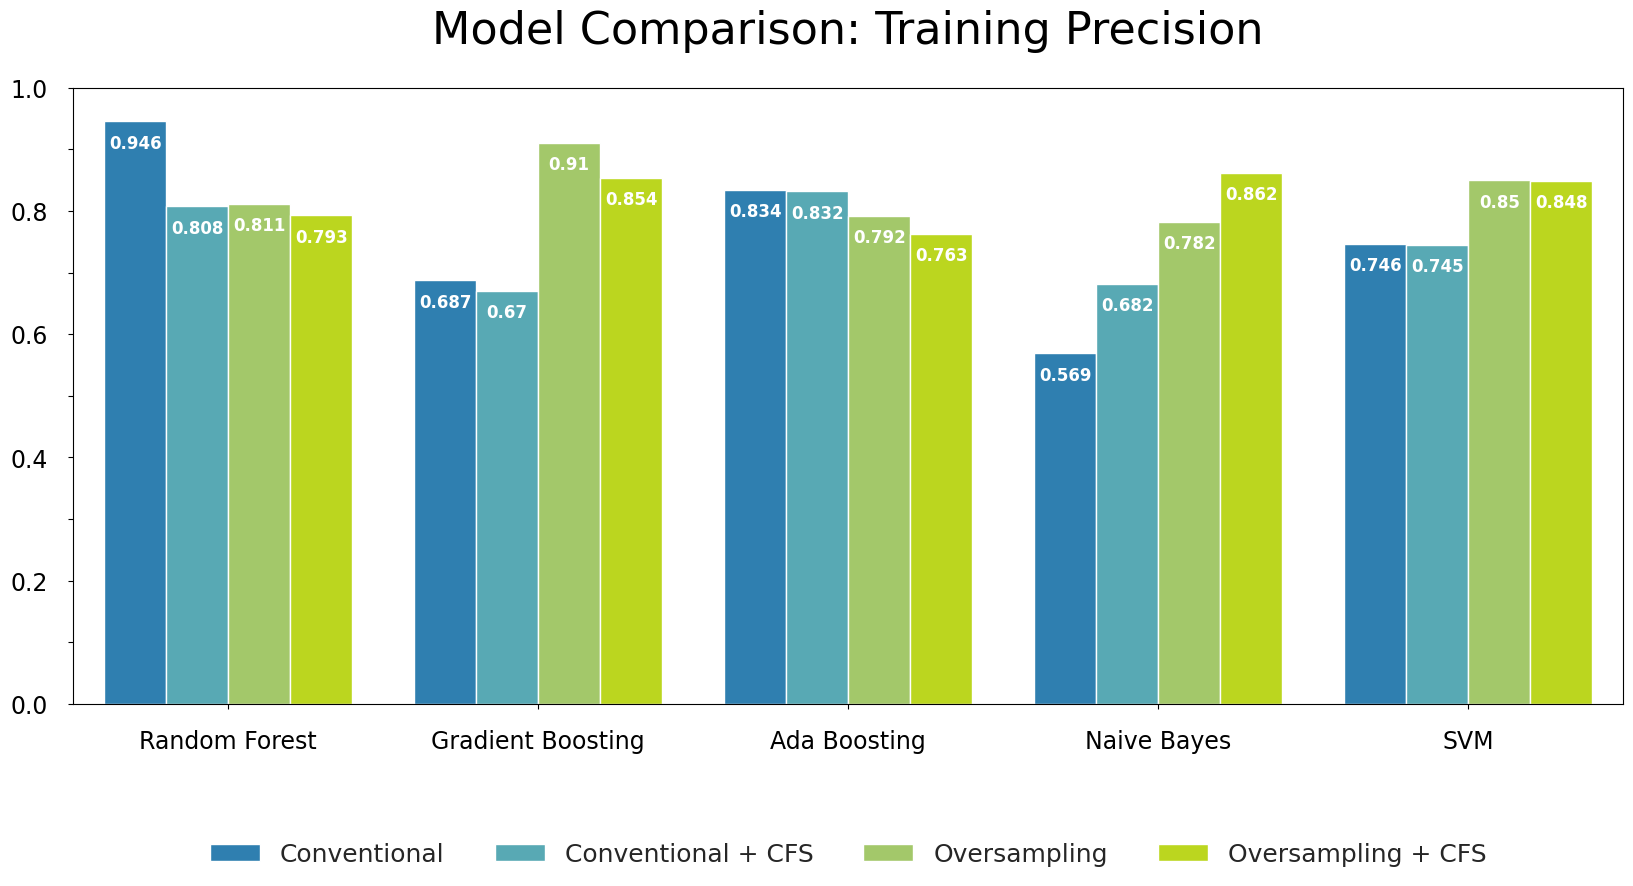

In [ ]:
train_results_df['Sample Combo'] = train_results_df.apply(lambda row: row['Sampling Technique']
                                                        + ' + ' + row['Feature Selection']
                                                        if row['Feature Selection'] != 'None'
                                                        else row['Sampling Technique'],
                                                        axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

custom_palette = {'Conventional': '#1984c5', 'Conventional + CFS': '#48b5c4',
                  'Oversampling': '#a6d75b', 'Oversampling + CFS': '#d0f400'}


sns.set_theme(style='whitegrid')
ax = sns.barplot(data=train_results_df,
            x='ML Method',
            y='Training Precision',
            hue='Sample Combo',
            palette=custom_palette)

# ax.get_xaxis().set_visible(False)
ax.set_title('Model Comparison: Training Precision', fontsize=32, pad=32)
ax.tick_params(axis='both', labelsize=17, pad=15)
ax.set_xlabel("")
# ax.set_ylabel("Precision", fontsize=20, labelpad=25)
ax.set_ylabel("")

ax.legend()
sns.move_legend(ax, "lower center", fontsize= 18,
                bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

for bar in ax.patches:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, height - 0.035, round(height, 3),
          ha='center', va='center', color='white', fontweight='semibold')

plt.yticks(np.linspace(0, 1, 11))
for label in ax.yaxis.get_ticklabels()[1::2]:
  label.set_visible(False)

plt.show()

#### **Discussing the results**



##### **The top performers in precision**
    
  - **A Random Forest is the top performer in precision:** Such a classifier trained on the conventional sample achieved the highest such score, `0.946`. In that regard, it substantially leads by ~`0.04` the next-best score, that `0.908` achieved by a Gradient Boosting model trained on the rebalanced & unreduced ('os') sample.

  - **Gradient Boosting is the next-most precise, and outclasses the RF in other respects:** Though its precision might be substantially inferior to that of the optimal Random Forest, the Gradient Boosting classifier from the 'oversampled and not CFS-reduced' sample has other merits worth considering. It far outmatches all the other models in this table's remaining performance metrics: accuracy, recall, and F1. In fact, the Gradient Boosting models appear to have all excelled in these metrics.

  - **The other ML methods' top models scored `0.04` less in precision or worse, compared to the Gradient Boosting one at second banana.** The scores of the best models from the Ada Boosting, Naive Bayes, and SVM models neighbored each other by roughly `0.01`.

##### **Other takeaways**


  - **The Naive Bayes method yielded both the least precise model and the third-most.** The former was trained on the conventional sample, while the latter was trained on the sample that was both rebalanced (through oversampling) and reduced through correlation-based feature selection.
    - **Also, these NB models fared better on the feature-selected samples than on the unreduced counterparts.** This goes counter to my expectations, as I imagine feature selection as typically removing information and, in turn, removing predictive power.

  - **No sample appears to be the clear front-runner:** There isn't one sample that is clearly favored by most models, nor is there a clearly disfavorable one.

    - **Oversampling was a mixed bag:** It led to worse models for Random Forest or Ada Boosting, but much better ones for Gradient Boosting, Naive Bayes, and SVM.

This training has yielded some interesting results. Having discussed them in some detail, I now move on to test validation.

#### **Saving results to file**

In [ ]:
# Save gridsearch dict and validation result df to files (if the gridsearches
# were indeed ran, rather than loaded from file.)
if run_the_gridsearches:
  # Save dictionary of gridsearches to pickle file
  path_to_data_dir = f'{project_dir_path}modelling_results/gridsearch_dicts/'
  !mkdir -p {path_to_data_dir}

  with open(f'{path_to_data_dir}gridsearch_dict{timestamp_of_run}.pkl', 'wb') as file:
    pickle.dump(gs_dict, file)

  # Save table of validation results to pickle file
  path_to_data_dir = f'{project_dir_path}modelling_results/val_results_dfs/pkl/'
  !mkdir -p {path_to_data_dir}
  train_results_df.to_pickle(f'{path_to_data_dir}train_results_df{timestamp_of_run}.pkl')

  # Save table of validation results to csv file
  path_to_data_dir = f'{project_dir_path}modelling_results/val_results_dfs/csv/'
  !mkdir -p {path_to_data_dir}
  train_results_df.to_csv(f'{path_to_data_dir}train_results_df{timestamp_of_run}.csv')


### **Testing**

#### **Setup**

##### **Table for testing validation results**

In [ ]:
# Empty dataframe to store the test validation results. Ensemble methods are the
# focus of my modelling.
test_results_df = pd.DataFrame({'ML Method':[],
                               'Class Balance':[],
                               'Sampling Technique':[],
                               'Feature Selection':[],
                               'Test Precision':[],
                               'Test Accuracy':[],
                               'Test Recall':[],
                               'Test F1':[],
                               'Estimators':[],
                               'Criterion':[],
                               'Loss':[],
                               'Max Depth':[],
                               'Min Samples Split':[],
                               'Learning Rate':[]
                                  })
test_results_df.T

""
ML Method
Class Balance
Sampling Technique
Feature Selection
Test Precision
Test Accuracy
Test Recall
Test F1
Estimators
Criterion


##### **Function definition:**

My function for evaluating the test performances of the models closely resembles that for the training. It too recognizes the subject of evaluation from a specification string, and outputs a record of a model's performance.

But this method for test differs slightly by taking a different parameter. It still takes a string specifying sample and method, but that's as part of a dictionary pair, one that also includes the fitted gridsearch object corresponding.

###### ***test_model_from_gs_dict_item()***

In [ ]:
def test_model_from_gs_dict_item(gs_dict_item):
  """ Given an item from the gridsearch dictionary, run its model on the test
  data and return a record of its performance (for the test_results_df.)"""

  gs_name = gs_dict_item[0]
  gs = gs_dict_item[1]

  ## SELECT RELEVANT DATA AND NOTE CHARACTERISTICS OF SAMPLE AND MODEL

  # From the gridsearch's name, parse which sample it corresponds to.
  # (Rather than parsing for the ML method as well here, that information will
  # instead be retrieved later from the gridsearch object, itself.)
  _, sample_abbr = gs_name.split('_', 1)

  # According to training sample, select the relevant test sets of predictors
  # and labels.
  # Also, note some metadata of the training sample in a partial record.
  X_test_set, y_test_set, train_sample_info = None, None, None
  match sample_abbr:
    case 'cs':
      X_test_set = X_test_cs
      y_test_set = y_test_cs
      train_sample_info = ['91-9', 'Conventional', 'None']
    case 'cs_cfs':
      X_test_set = X_test_cs_cfs
      y_test_set = y_test_cs_cfs
      train_sample_info = ['91-9', 'Conventional', 'CFS']
    case 'os':
      X_test_set = X_test_os
      y_test_set = y_test_os
      train_sample_info = ['75-25', 'Oversampling', 'None']
    case 'os_cfs':
      X_test_set = X_test_os_cfs
      y_test_set = y_test_os_cfs
      train_sample_info = ['75-25', 'Oversampling', 'CFS']

  # Determine and note the ML method / classifier type from the gridsearch,
  # directly.
  ml_method = gs.get_params()['estimator']
  clf_type = ''
  if isinstance(ml_method, RandomForestClassifier):
    clf_type = 'Random Forest'
  elif isinstance(ml_method, GradientBoostingClassifier):
    clf_type = 'Gradient Boosting'
  elif isinstance(ml_method, AdaBoostClassifier):
    clf_type = 'Ada Boosting'
  elif isinstance(ml_method, GaussianNB):
    clf_type = 'Naive Bayes'
  elif isinstance(ml_method, SVC):
    clf_type = 'SVM'


  # Create partial record of the learning method and sample metadata
  lm_and_sample_record = [clf_type, *train_sample_info]


  # Retrieve model's parameters from the gridsearch and log them in
  # another segment of the record.
  if clf_type not in ['Random Forest', 'Gradient Boosting', 'Ada Boosting']:
    param_record = ['N/A'] * 6
  else:
    hps = gs.best_estimator_.get_params()
    param_record = [hps['n_estimators'], 'N/A', 'N/A', 1, 2, 'N/A']
    if 'criterion' in hps:
      param_record[1] = hps['criterion']
    if 'loss' in hps:
      param_record[2] = hps['loss'].replace('_', ' ').title()
    elif clf_type == 'Ada Boosting':
      param_record[2] = 'Exponential Loss'
    if 'max_depth' in hps:
      param_record[3] = hps['max_depth']
    if 'min_samples_split' in hps:
      param_record[4] = hps['min_samples_split']
    if 'learning_rate' in hps:
      param_record[5] = hps['learning_rate']


  ## RUN TEST VALIDATION OF THE MODEL
  test_preds = gs.predict(X_test_set)
  test_classif_dict = classification_report(test_preds, y_test_set,
                                            output_dict=True, zero_division=0)

  test_acc = test_classif_dict['accuracy']
  test_f1 = test_classif_dict['macro avg']['f1-score']
  test_precision = test_classif_dict['macro avg']['precision']
  test_recall = test_classif_dict['macro avg']['recall']

  # Log the test performance in a final segment of the test validation record.
  test_perf_record = [test_precision, test_acc, test_recall, test_f1]

  # Assemble from the segments a full record of the test validation results,
  # then return it.
  full_test_record = lm_and_sample_record + test_perf_record + param_record
  return full_test_record

#### **Execution**

In [ ]:
for index, gs_dict_entry in enumerate(gs_dict.items()):
  test_results_df.loc[index+1] = test_model_from_gs_dict_item(gs_dict_entry)

In [ ]:
test_results_df.sort_values(by='Test Precision', ascending=False)

,ML Method,Class Balance,Sampling Technique,Feature Selection,Test Precision,Test Accuracy,Test Recall,Test F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
18,Ada Boosting,75-25,Oversampling,CFS,0.864000,0.898336,0.727220,0.771593,400,N/A,Exponential Loss,1,2,1
11,Random Forest,75-25,Oversampling,None,0.853519,0.919593,0.762414,0.798343,150,gini,N/A,7,2,N/A
13,Ada Boosting,75-25,Oversampling,None,0.848422,0.910351,0.744213,0.782921,400,N/A,Exponential Loss,1,2,1
16,Random Forest,75-25,Oversampling,CFS,0.847403,0.908503,0.740855,0.779953,150,gini,N/A,7,2,N/A
15,SVM,75-25,Oversampling,None,0.829715,0.940850,0.823973,0.826811,N/A,N/A,N/A,N/A,N/A,N/A
20,SVM,75-25,Oversampling,CFS,0.828696,0.939002,0.817468,0.822952,N/A,N/A,N/A,N/A,N/A,N/A
14,Naive Bayes,75-25,Oversampling,None,0.822287,0.911275,0.743616,0.775052,N/A,N/A,N/A,N/A,N/A,N/A
4,Naive Bayes,91-9,Conventional,None,0.814061,0.920518,0.763804,0.785871,N/A,N/A,N/A,N/A,N/A,N/A
19,Naive Bayes,75-25,Oversampling,CFS,0.812462,0.941774,0.833351,0.822464,N/A,N/A,N/A,N/A,N/A,N/A
12,Gradient Boosting,75-25,Oversampling,None,0.799649,0.942699,0.842973,0.819418,400,friedman_mse,Log Loss,7,2,0.1


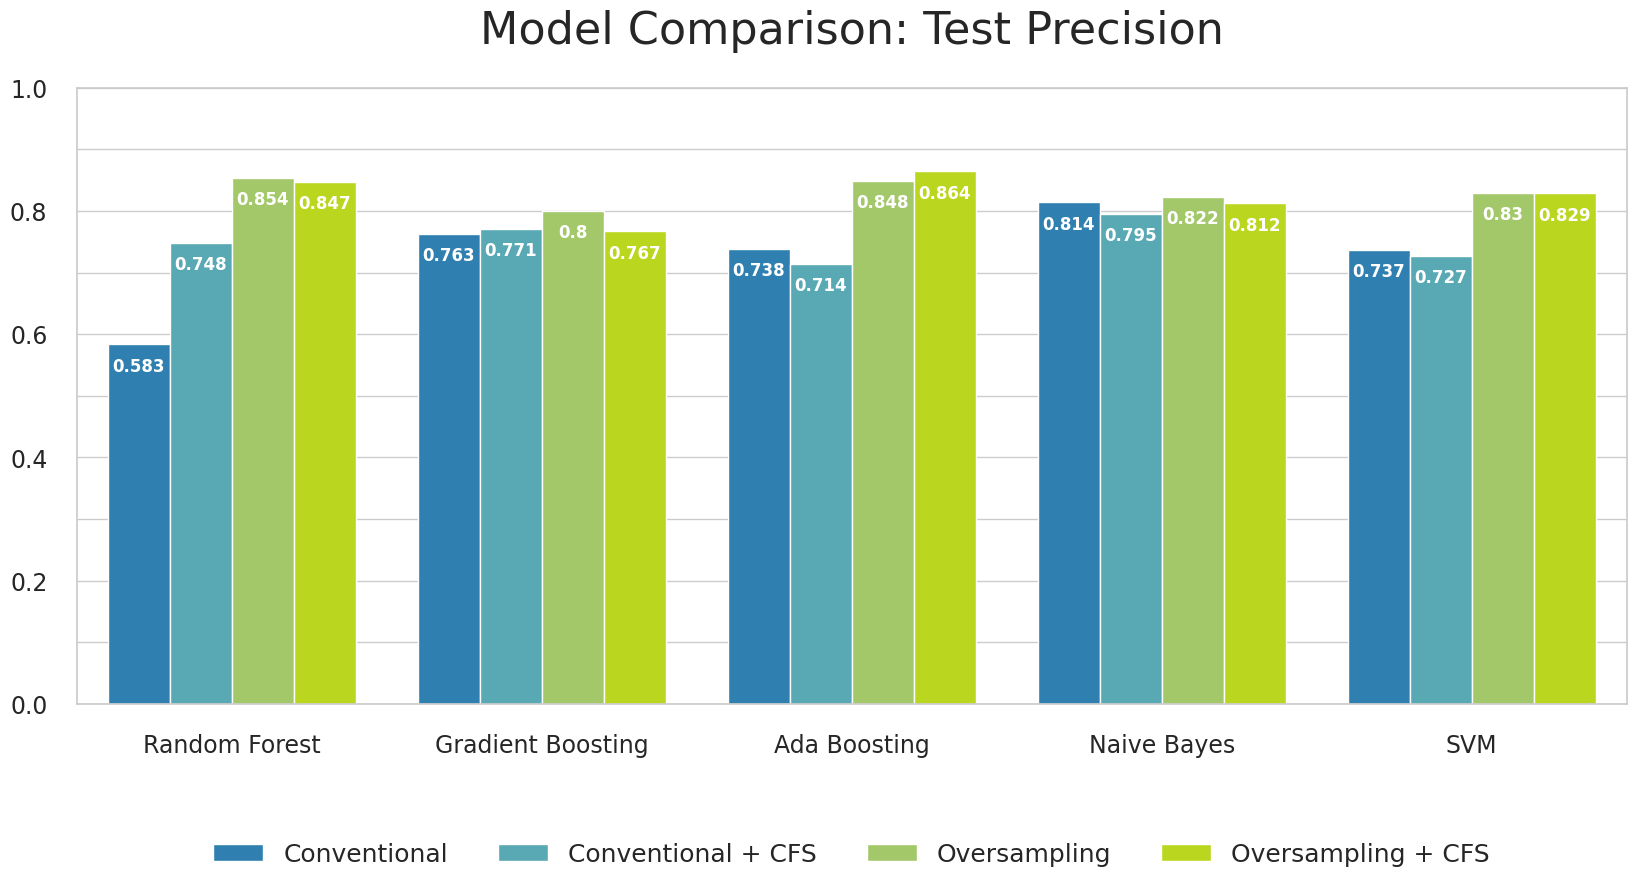

In [ ]:
test_results_df['Sample Combo'] = test_results_df.apply(lambda row: row['Sampling Technique']
                                                        + ' + ' + row['Feature Selection']
                                                        if row['Feature Selection'] != 'None'
                                                        else row['Sampling Technique'],
                                                        axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

custom_palette = {'Conventional': '#1984c5', 'Conventional + CFS': '#48b5c4',
                  'Oversampling': '#a6d75b', 'Oversampling + CFS': '#d0f400'}


sns.set_theme(style='whitegrid')
ax = sns.barplot(data=test_results_df,
            x='ML Method',
            y='Test Precision',
            hue='Sample Combo',
            palette=custom_palette)

# ax.get_xaxis().set_visible(False)
ax.set_title('Model Comparison: Test Precision', fontsize=32, pad=32)
ax.tick_params(axis='both', labelsize=17, pad=15)
ax.set_xlabel("")
# ax.set_ylabel("Precision", fontsize=20, labelpad=25)
ax.set_ylabel("")

ax.legend()
sns.move_legend(ax, "lower center", fontsize= 18,
                bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

for bar in ax.patches:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, height - 0.035, round(height, 3),
          ha='center', va='center', color='white', fontweight='semibold')

plt.yticks(np.linspace(0, 1, 11))
for label in ax.yaxis.get_ticklabels()[1::2]:
  label.set_visible(False)

plt.show()

#### **Discussing the results**

##### **The top performers in precision**

- **The four most precise models came from Ada Boosting and Random Forest models trained on the oversampled datasets.** The next-highest precision scores came from the SVM and Naive Bayes methods.
  - **Gradient Boosting's best model scored only the tenth-highest precision** of the twenty models.

- **The top-performing combination of method and sample from training did the worst here in test,** namely the Random Forest trained on the conventional sample. This suggests that the model may have been severely overfitted.

##### **Other takeaways**

- **The oversampled datasets consistently trained the most precise model for each learning method.** In training, a couple methods rather yielded worse models when trained thereon.
  - The Gradient Boosting and Naive Bayes models scored the most similar precisions, within each method. I wonder if this suggests stability across these sampling differences.

- **Ensemble learning methods yielded the most precise methods, but perhaps by a narrower margin than I was expecting.** Their advantages might be even less remarkable to me considering their much lengthier training times, here.

- **Feature selection drastically reduced training times, without drastically costing the precision.** In one case, for Ada Boosting on the oversampled datasets, the model trained on the feature-selected data even performed better.

- **SVM now rivals Gradient Boosting in providing competitively precise models that also score well in accuracy, recall, and F1.**


Between this testing and the training, there were some stark reversals of observed patterns. These might affirm the unquestionable importance of test validation, as well as underscore the risks of overinterpreting the results of training, or lingering too long there.

#### **Saving results to file**

In [ ]:
# Save gridsearch dict and validation result df to files
if run_the_gridsearches:
  path_to_data_dir = f'{project_dir_path}modelling_results/test_results_dfs/pkl/'
  !mkdir -p {path_to_data_dir}
  test_results_df.to_pickle(f'{path_to_data_dir}test_results_df{timestamp_of_run}.pkl')

  path_to_data_dir = f'{project_dir_path}modelling_results/test_results_dfs/csv/'
  !mkdir -p {path_to_data_dir}
  test_results_df.to_csv(f'{path_to_data_dir}test_results_df{timestamp_of_run}.csv')